In [1]:
import netCDF4
import xarray as xr
import numpy as np
import pandas as pd
import os, glob
import matplotlib.pyplot as plt
import geopandas as gpd
from datetime import timedelta
from scipy.stats import pearsonr
import cartopy.crs as ccrs
import seaborn as sns
crs = ccrs.NorthPolarStereo()
crs_proj4 = crs.proj4_init

In [2]:
os.chdir('/data/dhence/a/pborse2/inputdata/data.eol.ucar.edu/pub/download/extra/katz_data/stage4/daily_data')
fi = [f for f in glob.glob('*.nc')]
fi.sort()
# fiopen = [xr.open_dataset(i) for i in fi]


In [3]:
def hrap_from_latlon(lat, lon):
    ####### Calculate the latitude and longitude for a HRAP grid.
    raddeg = 57.29577951
    earthrad = 6371.2
    stdlon = 105.
    mesh_len = 4.7625
    tlat = 60. / raddeg
    
    R = earthrad*np.cos(lat/raddeg)*(1+np.sin(tlat))/(1+np.sin(lat/raddeg))
    
    x = R*np.cos((lon+15)/raddeg)
    y = R*np.sin((lon+15)/raddeg)
    
    hrap_x = 401+ (x/mesh_len)
    hrap_y = 1601+ (y/mesh_len)

    return hrap_x, hrap_y


In [4]:
#streamgage locations
latlon = pd.DataFrame({'longitude': [-88.1520, -88.3070, -88.21944, -88.22644], 'latitude': [40.1292, 40.0976, 40.11113, 40.11117]})

x = [hrap_from_latlon(latlon.iloc[i]['latitude'],latlon.iloc[i]['longitude'])[0] for i in range(len(latlon))]
y=  [hrap_from_latlon(latlon.iloc[i]['latitude'],latlon.iloc[i]['longitude'])[1] for i in range(len(latlon))]
latlon['longitude'] = x
latlon['latitude'] = y

geom = gpd.points_from_xy(latlon.longitude, latlon.latitude)
gage = gpd.GeoDataFrame(latlon, geometry=geom, crs = crs_proj4 )

<AxesSubplot:>

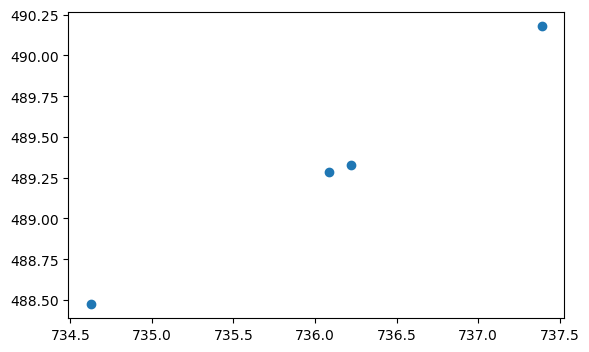

In [32]:
gage.plot()

In [7]:
###To check if the converted latlons fall in the right place
# ax=plt.subplot(1,1,1)
# fiopen['tp'].sel(time='2002-10-10').plot(ax=ax)
# gage.plot(ax=ax)

In [5]:
def projection(filelist):
    import cartopy.crs as ccrs
    crs = ccrs.NorthPolarStereo()
    crs_proj4 = crs.proj4_init
    fiopen = xr.open_mfdataset(filelist)
    fiopen = fiopen.rio.write_crs(crs_proj4 , inplace=True)
    fiopen['x']=fiopen.x
    fiopen['y']=fiopen.y
    fiopen=fiopen.set_index({'x':'x' ,'y':'y'})
    fiopen.attrs['pyproj_srs'] = crs_proj4
    return fiopen

In [6]:
fiopen = projection(fi)

In [8]:
copper = fiopen['tp'].sel(x = gage['longitude'][0],y=gage['latitude'][0], method= 'nearest') 
quad =  fiopen['tp'].sel(x = gage['longitude'][1],y=gage['latitude'][1], method= 'nearest') 
lincoln = fiopen['tp'].sel(x = gage['longitude'][2],y=gage['latitude'][2], method= 'nearest') 
saline = fiopen['tp'].sel(x = gage['longitude'][3],y=gage['latitude'][3], method= 'nearest') 

In [9]:
# stns = [copper,quad,lincoln,saline]
# import seaborn as sns
# for j in [copper,quad,lincoln,saline]:
#     j.groupby('time.year').mean().plot()
# #     plt.ylim(0,20)
# #     plt.show()

In [7]:
os.chdir('/data/dhence/a/pborse2/inputdata/Mosquito data')
from ipynb.fs.defs.Mosquitodataset1_Yearlybatchdata import yearlyfile, batch1, batchdf1
mos = yearlyfile("Mosquito yearly.xlsx",'U-C')[0]
mosyr = yearlyfile("Mosquito yearly.xlsx",'U-C')[1]
batch = batch1(mosyr,mos)
batchdf = batchdf1(mos)

/data/keeling/a/pborse2/Deanna Research/Research/Actual analysis/ISWSdataset_Champaign.ipynb:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  },
/data/keeling/a/pborse2/Deanna Research/Research/Actual analysis/ISWSdataset_Champaign.ipynb:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  },
/data/keeling/a/pborse2/Deanna Research/Research/Actual analysis/ISWSdataset_Champaign.ipynb:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

In [8]:
os.chdir('/data/dhence/a/pborse2/inputdata/srmflw_UC')
Ipeak = [pd.read_csv(i) for i in glob.glob('*.csv')]

In [10]:
disseason = [i[(pd.to_datetime(i['date']).dt.month>=6) & (pd.to_datetime(i['date']).dt.month<=9)] for i in Ipeak]

In [13]:
stns = [copper,quad,lincoln,saline]
R2 = []
for i in range(len(disseason)):
    R=[]
    s=-1
    for j in range(2002,2020):
        s=s+1
        q = disseason[i][pd.to_datetime(disseason[i]['date']).dt.year==j][disseason[i].columns[2]]
        rain = stns[i][stns[i]['time'].dt.year==j]
        rain = rain[(rain['time'].dt.month>=6) & (rain['time'].dt.month<=9)]
        try:
            newdf=pd.DataFrame({'rain':rain.values[:243], 'strmflw': q.values[:243]})
            newdf.dropna()
            r2 = newdf.corr()
            R.append(r2)
        except:
            pass
    R2.append(R)

In [14]:
[R2[2][i]['strmflw']['rain'] for i in range(len(R2[2]))]

[0.23821504208401256,
 0.31359017601225964,
 0.18880009102828385,
 0.5914072266627958,
 0.723030929084168,
 0.2056959570353318,
 0.45406909074918084,
 0.43031710785456456,
 0.47709398109950557,
 0.4466803699422969,
 0.5152313715259597,
 0.2569184638048897,
 0.3487989491724184,
 0.42026695268881675,
 0.5723924935419473,
 0.5742014164254916]

In [10]:
iswsx=hrap_from_latlon(40.084074, -88.240311)[0]
iswsy=hrap_from_latlon(40.084074, -88.240311)[1]

In [17]:
fiopen

<xarray.Dataset>
Dimensions:      (time: 6552, y: 881, x: 1121)
Coordinates:
  * time         (time) datetime64[ns] 2001-12-31T12:00:00 ... 2019-12-31T12:...
    step         timedelta64[ns] 1 days
    surface      float64 0.0
    latitude     (y, x, time) float64 dask.array<chunksize=(881, 1121, 364), meta=np.ndarray>
    longitude    (y, x, time) float64 dask.array<chunksize=(881, 1121, 364), meta=np.ndarray>
    valid_time   (time) datetime64[ns] dask.array<chunksize=(364,), meta=np.ndarray>
    spatial_ref  int64 0
  * x            (x) int64 0 1 2 3 4 5 6 ... 1114 1115 1116 1117 1118 1119 1120
  * y            (y) int64 0 1 2 3 4 5 6 7 8 ... 873 874 875 876 877 878 879 880
Data variables:
    tp           (time, y, x) float32 dask.array<chunksize=(364, 881, 1121), meta=np.ndarray>
Attributes:
    GRIB_edition:            1
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP 
    GRIB_subCentre:          4
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP 
    history:                 2022-07-28T18:20 GRIB to CDM+CF via cfgrib-0.9.1...
    pyproj_srs:              +ellps=WGS84 +proj=stere +lat_0=90 +lon_0=0.0 +x...

In [11]:
isws = fiopen['tp'].sel(x = iswsx,y=iswsy, method= 'nearest')

In [8]:
from ipynb.fs.full.ISWSdataset_Champaign import aprnov
csv=[pd.read_csv(f) for f in glob.glob("/data/dhence/a/pborse2/inputdata/ISWS_data/Champaign/*.csv")]
ppt = [aprnov(csv)[i] for i in range(3,len(aprnov(csv)))]

/data/keeling/a/pborse2/Deanna Research/Research/Actual analysis/ISWSdataset_Champaign.ipynb:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  },
/data/keeling/a/pborse2/Deanna Research/Research/Actual analysis/ISWSdataset_Champaign.ipynb:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  },
/data/keeling/a/pborse2/Deanna Research/Research/Actual analysis/ISWSdataset_Champaign.ipynb:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

/data/keeling/a/pborse2/Deanna Research/Research/Actual analysis/ISWSdataset_Champaign.ipynb:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  },
/data/keeling/a/pborse2/Deanna Research/Research/Actual analysis/ISWSdataset_Champaign.ipynb:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  },
/data/keeling/a/pborse2/Deanna Research/Research/Actual analysis/ISWSdataset_Champaign.ipynb:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

/data/keeling/a/pborse2/Deanna Research/Research/Actual analysis/ISWSdataset_Champaign.ipynb:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  },
/data/keeling/a/pborse2/Deanna Research/Research/Actual analysis/ISWSdataset_Champaign.ipynb:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  },
/data/keeling/a/pborse2/Deanna Research/Research/Actual analysis/ISWSdataset_Champaign.ipynb:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

/data/keeling/a/pborse2/Deanna Research/Research/Actual analysis/ISWSdataset_Champaign.ipynb:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  },
/data/keeling/a/pborse2/Deanna Research/Research/Actual analysis/ISWSdataset_Champaign.ipynb:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  },
/data/keeling/a/pborse2/Deanna Research/Research/Actual analysis/ISWSdataset_Champaign.ipynb:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

/data/keeling/a/pborse2/Deanna Research/Research/Actual analysis/ISWSdataset_Champaign.ipynb:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  },
/data/keeling/a/pborse2/Deanna Research/Research/Actual analysis/ISWSdataset_Champaign.ipynb:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  },
/data/keeling/a/pborse2/Deanna Research/Research/Actual analysis/ISWSdataset_Champaign.ipynb:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

/data/keeling/a/pborse2/Deanna Research/Research/Actual analysis/ISWSdataset_Champaign.ipynb:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  },
/data/keeling/a/pborse2/Deanna Research/Research/Actual analysis/ISWSdataset_Champaign.ipynb:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  },
/data/keeling/a/pborse2/Deanna Research/Research/Actual analysis/ISWSdataset_Champaign.ipynb:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

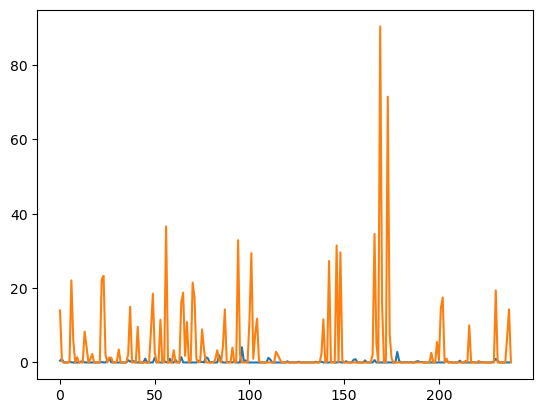

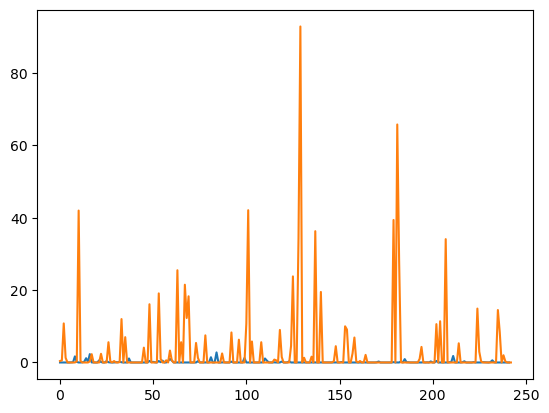

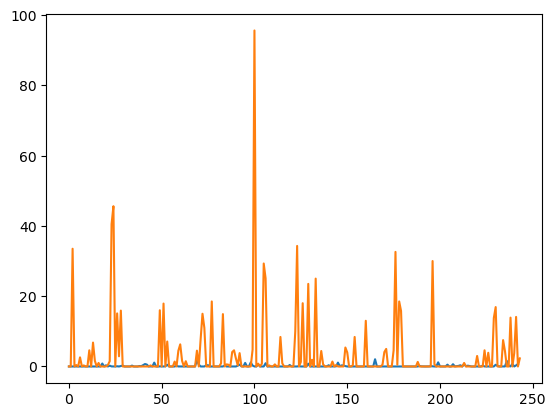

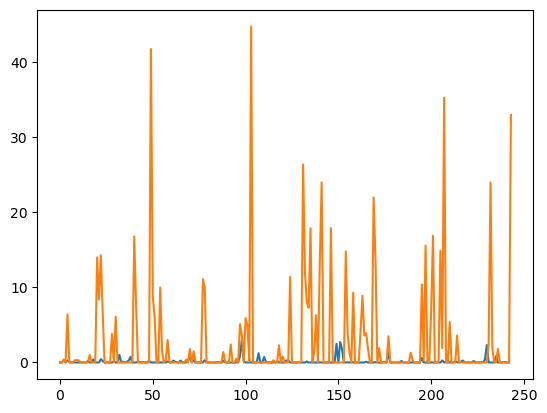

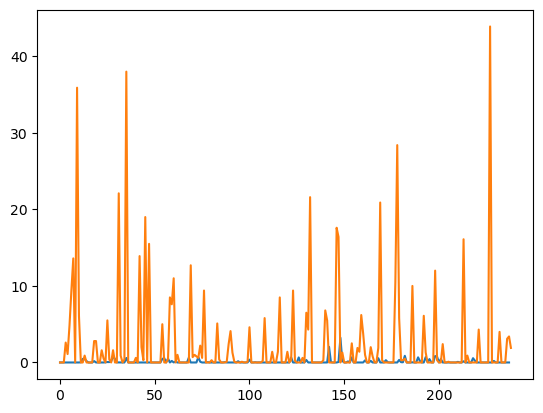

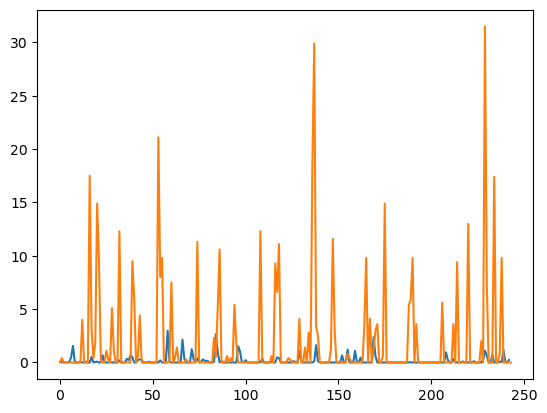

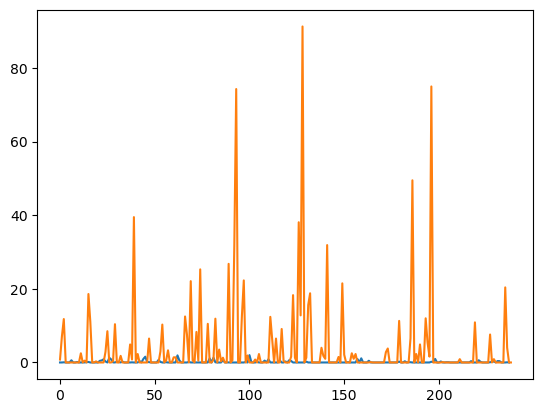

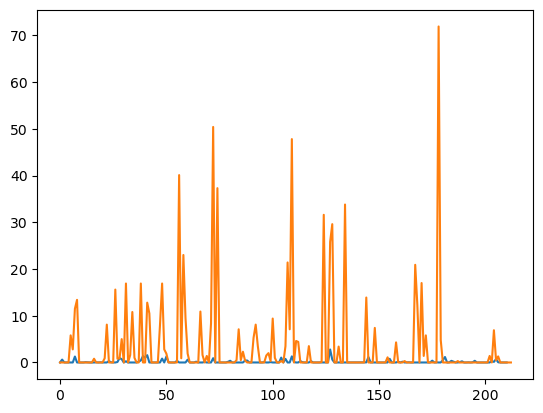

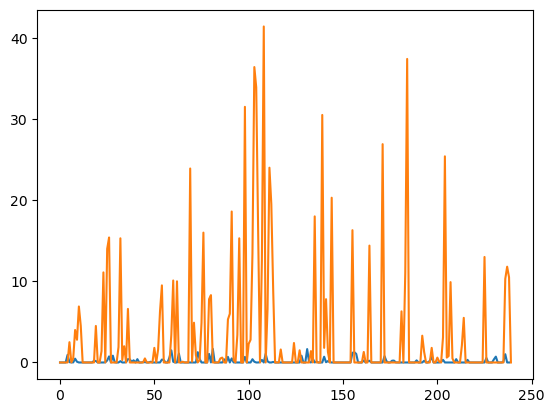

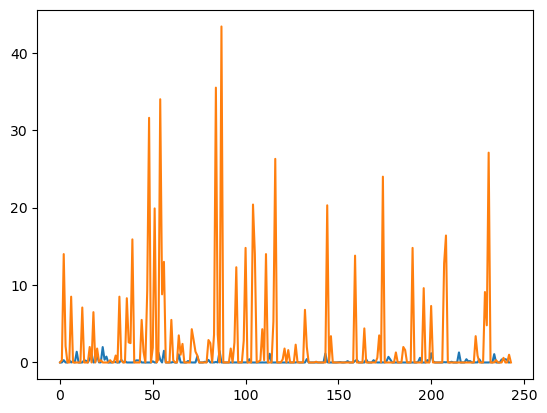

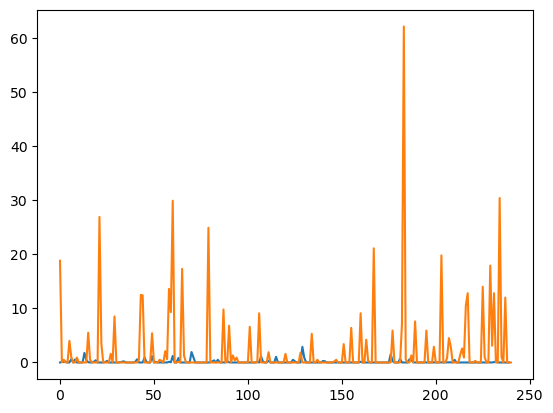

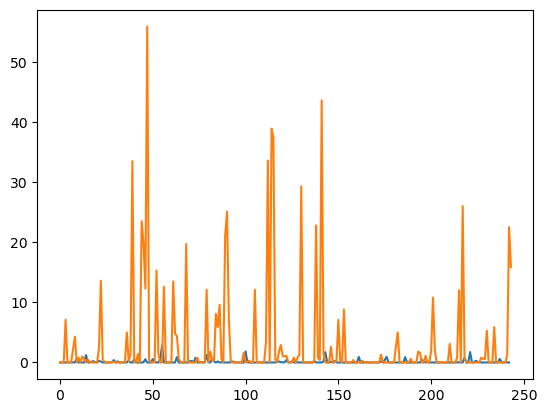

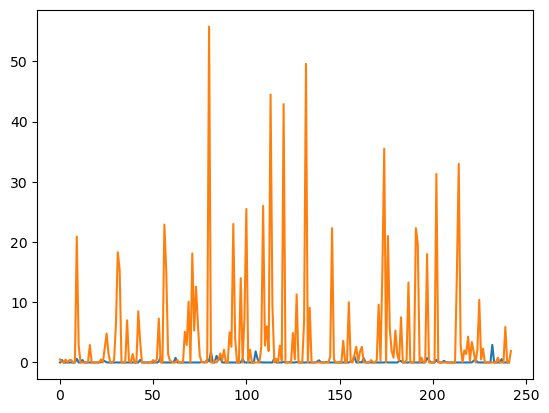

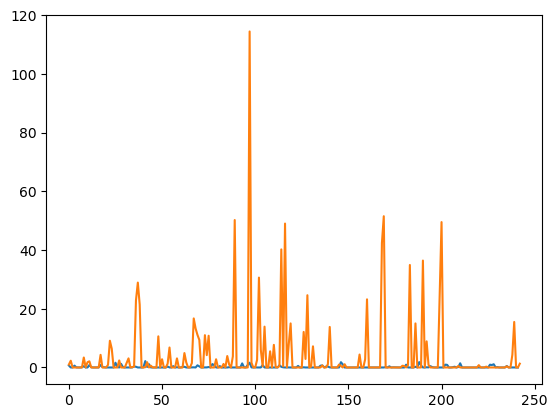

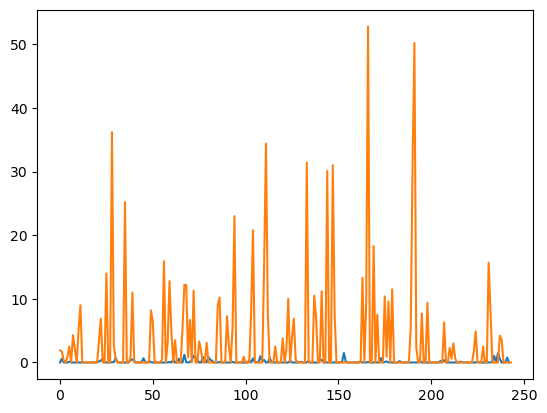

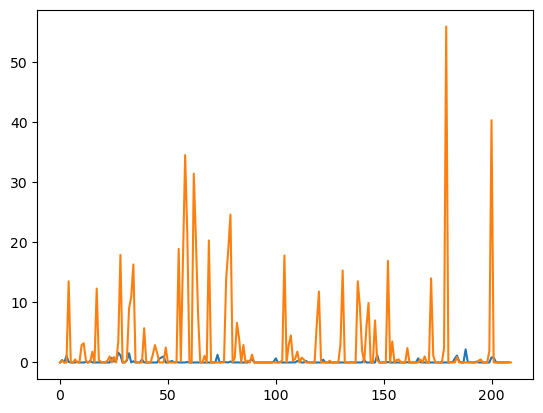

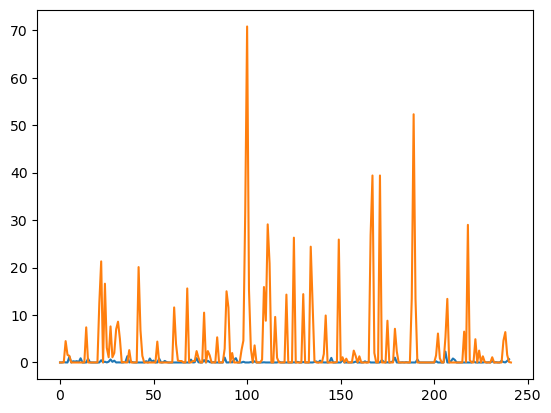

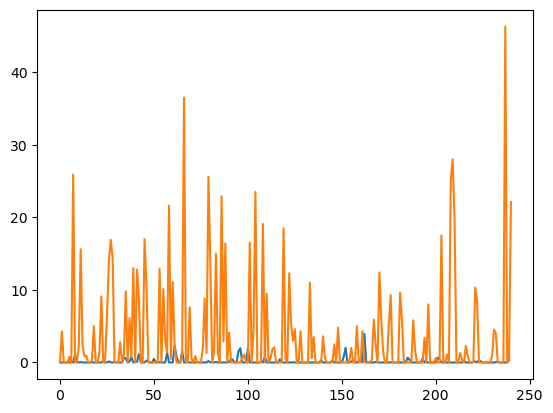

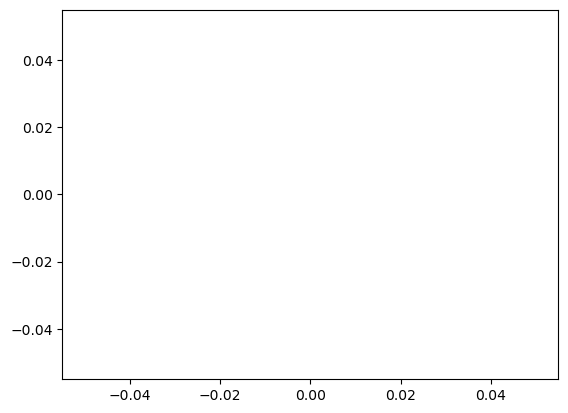

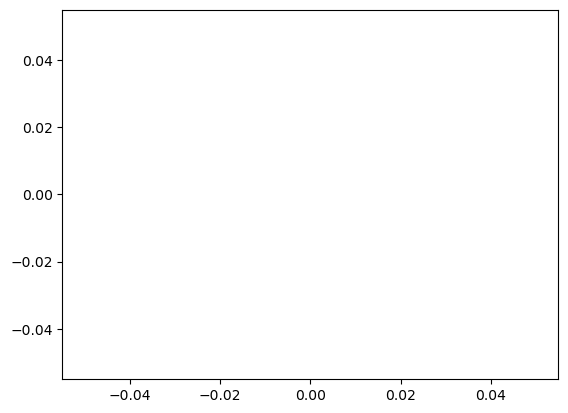

In [56]:
for i in range(len(ppt)):
#     print(len(isws[i]),len(aprnov(csv)[i+3]))
    dat = set(isws['time'].dt.date.values).intersection(set(ppt[i].index.date+timedelta(1)))
    isws = isws.fillna(0)
    dat = pd.to_datetime(list(dat))
    ppt[i]['TOTAL PRECIP oF'] = ppt[i]['TOTAL PRECIP oF'].fillna(0)
    dat1 = dat-timedelta(1)
#     print('dat',len(dat),len(dat1))
    plt.plot(ppt[i][ppt[i].index.isin(dat)]['TOTAL PRECIP oF'].values)
    plt.plot(isws[isws['time'].dt.date.isin(dat.date)].values)
    plt.show()
#     try:
#         k = pearsonr(ppt[i][ppt[i].index.isin(dat)]['TOTAL PRECIP oF'],isws[isws['time'].dt.date.isin(dat1.date)])
# #         print(k[0])
#     except:
#         print(len(ppt[i][ppt[i].index.isin(dat)]['TOTAL PRECIP oF']),len(isws[isws['time'].dt.date.isin(dat1.date)]))

In [22]:
usgs = pd.read_parquet('/data/dhence/a/pborse2/inputdata/boneyard_ppt.parquet').fillna(0)
usgssum =usgs[['USGS:03337000:00045:00000']].groupby(usgs.index.date).sum() 
usgssum['USGS:03337000:00045:00000'] = usgssum['USGS:03337000:00045:00000'].values*25.4

In [23]:
usgssum.index = pd.to_datetime(usgssum.index)

2002
2003
2004
2005
2006
0.5692117843651602
0.527761593288627
2009
0.43545726880616714
0.36138534125588745
0.4897870979637914
0.3912314731689588
0.5940535392750984
0.4563638598337859
0.5458167788813646
0.3646447300152402
0.6316883184524051
0.5092137514606965


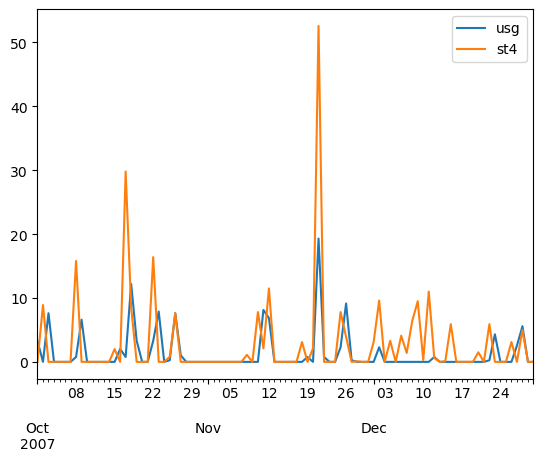

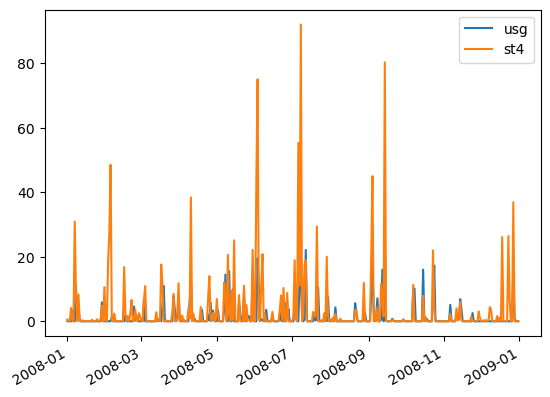

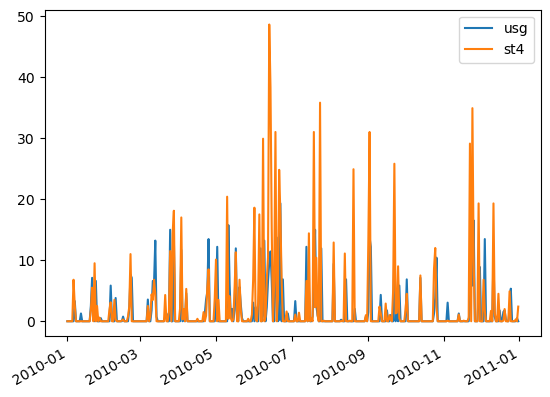

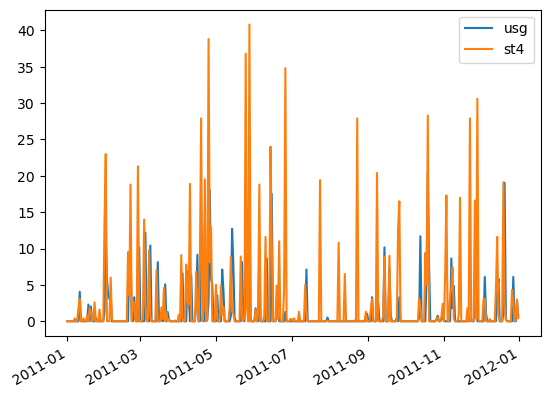

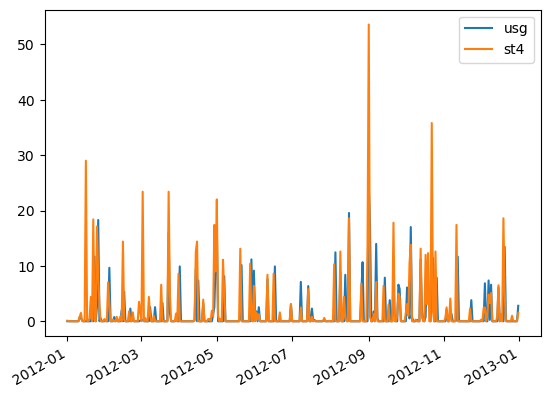

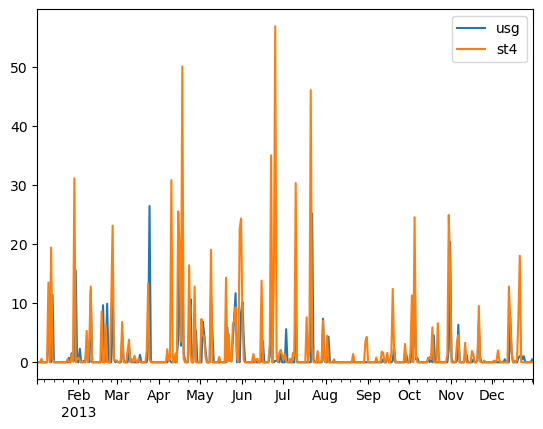

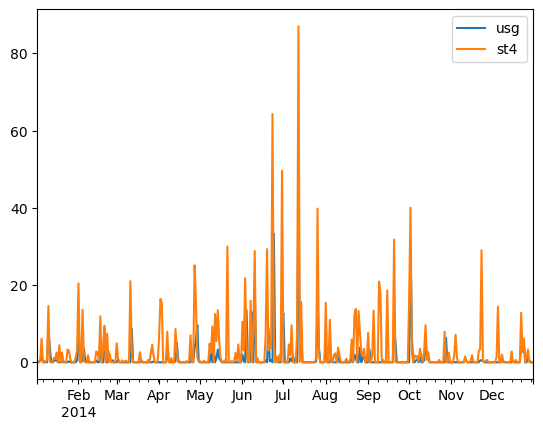

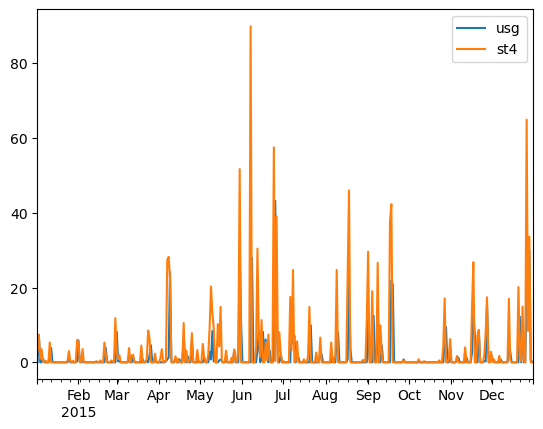

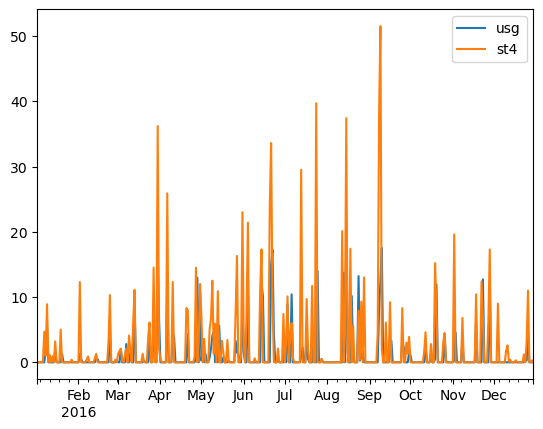

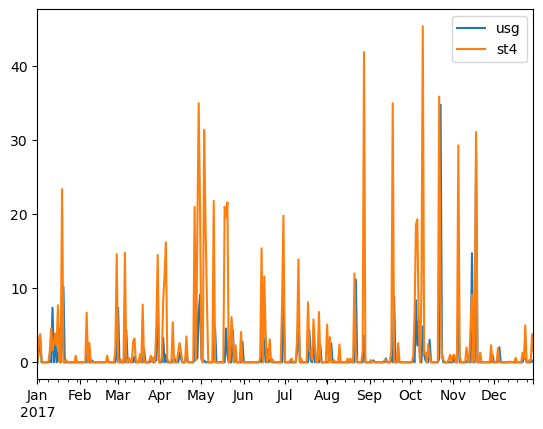

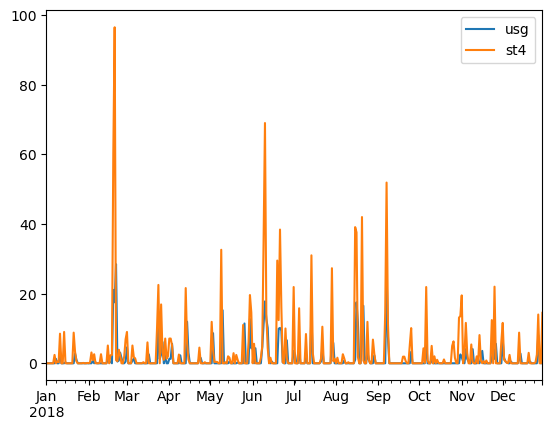

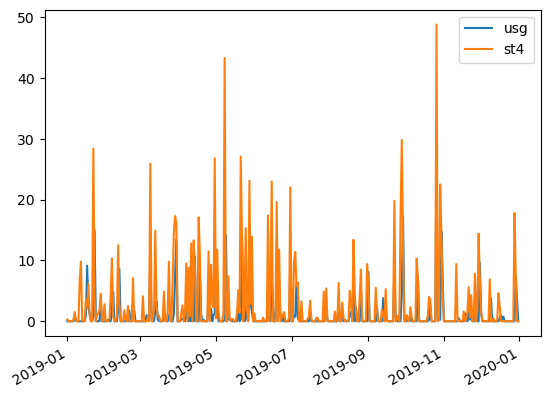

In [13]:
for i in range(2002,2020):
    quady = quad[quad['time'].dt.year==i]
    dat = usgssum[pd.to_datetime(usgssum.index).isin(pd.to_datetime(quady['time'].dt.date))].index
    try:
        usg = usgssum[usgssum.index.isin(dat)]['USGS:03337000:00045:00000']
        st4 = quady[pd.to_datetime(quady['time'].dt.date).isin(dat)]
        df= pd.DataFrame({'usg':usg,'st4':st4})
        df = df.dropna()
        k = pearsonr(df['usg'],df['st4'])
        print(k[0])
        df.plot()
    except:
        print(i)

In [7]:
import matplotlib.pyplot as plt
def poly():
    from shapely.geometry import Polygon    
    import numpy as np


    lonmatup = [np.array([734.5,737.5,737.5,734.5])]
    latmatup = [np.array([487.25,487.25,490.5,490.5])]

    geom_list = [(x, y) for x, y in zip(lonmatup, latmatup)]

    geom_list_2 = [Polygon(tuple(zip(x, y))) for x, y in geom_list]
    plt.plot(*geom_list_2[0].exterior.xy,color='black')
    return geom_list_2

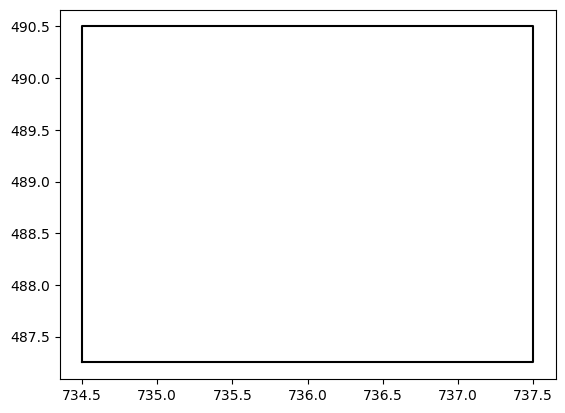

In [8]:
geom_list_2 = poly()


In [9]:
poly1 = gpd.GeoDataFrame(index=[0],crs = crs_proj4 ,geometry = geom_list_2)

In [115]:
fiopen

[<xarray.Dataset>
 Dimensions:      (time: 364, y: 881, x: 1121)
 Coordinates:
   * time         (time) datetime64[ns] 2001-12-31T12:00:00 ... 2002-12-29T12:...
     step         timedelta64[ns] 1 days
     surface      float64 0.0
     latitude     (y, x) float64 ...
     longitude    (y, x) float64 ...
     valid_time   (time) datetime64[ns] 2002-01-01T12:00:00 ... 2002-12-30T12:...
     spatial_ref  int64 0
   * x            (x) int64 0 1 2 3 4 5 6 ... 1114 1115 1116 1117 1118 1119 1120
   * y            (y) int64 0 1 2 3 4 5 6 7 8 ... 873 874 875 876 877 878 879 880
 Data variables:
     tp           (time, y, x) float32 ...
 Attributes:
     GRIB_edition:            1
     GRIB_centre:             kwbc
     GRIB_centreDescription:  US National Weather Service - NCEP 
     GRIB_subCentre:          4
     Conventions:             CF-1.7
     institution:             US National Weather Service - NCEP 
     history:                 2022-07-28T18:20 GRIB to CDM+CF via cfgrib-0.9.1...


In [10]:
champcity = fiopen['tp'].sel(x=slice(734.5,737.5),y=slice(488,490.5))

/tmp/ipykernel_80694/2994160879.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(champcity.sel(x=i,y=j),hist=False)
/tmp/ipykernel_80694/2994160879.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(champcity.sel(x=i,y=j),hist=False)
/tmp/ipykernel_80694/2994160879.py:3: Us

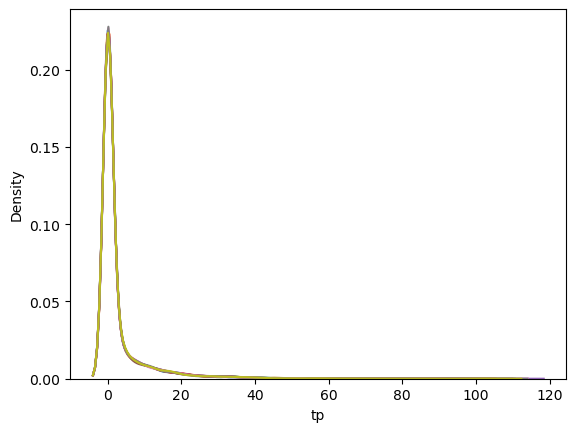

In [8]:
for i in champcity['x']:
    for j in champcity['y']:
        sns.distplot(champcity.sel(x=i,y=j),hist=False)

In [11]:
#Create a timeseries by taking spatial average of the data
cutempo = champcity.mean(('x','y'))[(champcity.time.dt.month>=4)&(champcity.time.dt.month<=11)] 

In [26]:
# for i in range(2003,2007):
#     plt.scatter(range(len(cutempo[cutempo!=0].groupby('time.year')[i])),cutempo[cutempo!=0].groupby('time.year')[i])
# # cutempo[cutempo!=0].plot()
len(cutempo[cutempo==0])

2586

In [13]:
# from datetime import timedelta

# for j in range(1,29):
#     td = timedelta(j)
# #     try:
#     t = cutempo['time'][cutempo.time.dt.date.isin((batchdf['date']-td).dt.date)]
# #     print(t)
# #         batchdf[(batchdf['date']-td).dt.date.isin(t)]['lag-'+str(j)]= cutempo[cutempo['time'].isin(t)]
# #     except:
# #         print(len(t))

In [28]:
#Finding threshold ppt when mosquito batches appear 
from datetime import timedelta
lagdays=[]
for j in range(29,57):
    laglist=[]
    for i in mosyr:
        batch3 = batchdf[batchdf['date'].dt.year==i]
        ppt = cutempo[cutempo.time.dt.year==i]
        td = timedelta(j)
        ppt = ppt[ppt.time.dt.date.isin((batch3['date']-td).dt.date)]
        data = zip(ppt.values,batch3['batches'].values)
        laglist.append(list(zip(ppt.values,batch3['batches'].values,batch3['date'])))
        #print(list(zip(ppt.values,batch['batches'].values)))
    laglist = sum(laglist,[])
    #print(laglist)
    lag = pd.DataFrame(laglist,columns = ['lag'+str(j), 'batch','date'])        
    lagdays.append(lag)


In [29]:
lagdays

[         lag29  batch       date
 0     0.822222      1 2002-07-11
 1     0.000000      2 2002-07-16
 2     3.122222      3 2002-07-23
 3     2.100000      3 2002-07-24
 4     0.000000      1 2002-07-31
 ..         ...    ...        ...
 140   1.633333      3 2018-08-31
 141   0.788889      3 2018-09-07
 142  40.333332      1 2018-09-14
 143   0.000000      3 2018-09-21
 144  12.166667      1 2018-10-05
 
 [145 rows x 3 columns],
          lag30  batch       date
 0    29.855556      1 2002-07-11
 1     0.000000      2 2002-07-16
 2     0.000000      3 2002-07-23
 3     3.122222      3 2002-07-24
 4     0.000000      1 2002-07-31
 ..         ...    ...        ...
 141   0.000000      3 2018-08-31
 142   0.000000      3 2018-09-07
 143  23.222221      1 2018-09-14
 144   0.000000      3 2018-09-21
 145   0.000000      1 2018-10-05
 
 [146 rows x 3 columns],
         lag31  batch       date
 0    4.800000      1 2002-07-11
 1    0.911111      2 2002-07-16
 2    0.000000      3 2002-07-2

In [30]:
b=lagdays[0]['batch']
d = lagdays[0]['date']
# for i in lagdays:
#     i['batch'] = b
#     i = i.set_index('batch',inplace=True)
lagdf = pd.concat(lagdays,axis=1,sort=False)

In [31]:
lagdf['batch']=b
lagdf['date'] =d
lagdf = lagdf.drop(['batch','date'],axis=1)

In [32]:
lagdf = lagdf.join(b)
lagdf = pd.concat([lagdf,d],axis=1)

In [33]:
lagdf.set_index('date',inplace=True)

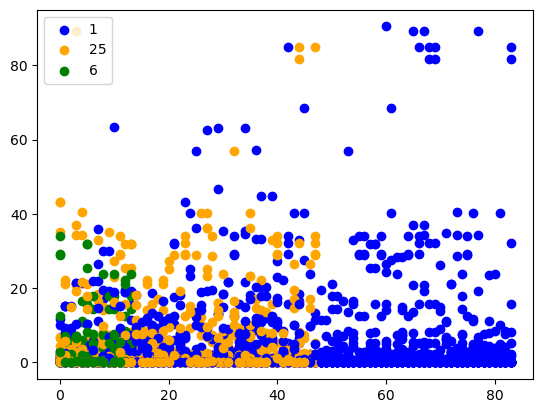

In [58]:
for i in lagdf.columns:
    plt.scatter(range(len(lagdf[(lagdf.batch==1)])),lagdf[(lagdf.batch==1)][i],color='blue')
    plt.scatter(range(len(lagdf[(lagdf.batch>=2)&(lagdf.batch<=5)])),lagdf[(lagdf.batch>=2)&(lagdf.batch<=5)][i],color='orange')
    plt.scatter(range(len(lagdf[(lagdf.batch>=6)])),lagdf[(lagdf.batch>=6)][i],color='green')
    plt.legend([1,25,6])


In [16]:

# for i in range(len(lagdf.columns)):
#     lagdf['ppt_weight-'+str(i+1)] =i*lagdf[lagdf.columns[i]]

In [20]:
# lagdf['totpptweight']= lagdf[lagdf.columns[28:]].sum(axis=1)

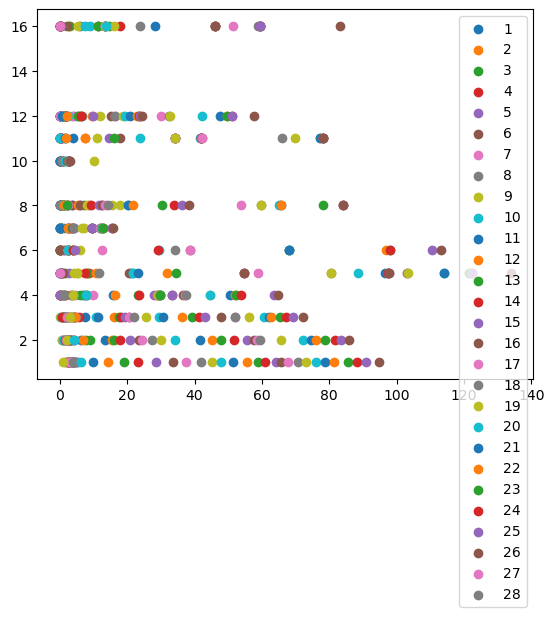

In [19]:
lagdf = lagdf.sort_values(by='batch')
# plt.boxplot(lagdf['totpptweight'].groupby(lagdf.index).apply(list))
# plt.show()
# for i in range(1,len(lagdf.columns)):
#     plt.boxplot(lagdf[lagdf.columns[:i]].sum(axis=1).groupby(lagdf.index).apply(list))
#     plt.show()
# for i in range(1,len(lagdf.columns)):
#     plt.scatter(lagdf[lagdf.columns[:i]].sum(axis=1).groupby(lagdf.index).mean(),list(dict.fromkeys(lagdf.index)))
#     plt.show()
for i in range(len(lagdf.columns)):
    plt.scatter(lagdf[lagdf.columns[i]].groupby(lagdf.batch).mean(),list(dict.fromkeys(lagdf.batch)))
plt.legend(range(1,29))

/tmp/ipykernel_41849/273876108.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(lagdf.groupby(lagdf.index.year)['lag2'].apply(list)[i],hist=False,ax=ax)
/tmp/ipykernel_41849/273876108.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(lagdf.groupby(lagdf.index.year)['lag2']

KstestResult(statistic=0.7142857142857143, pvalue=1.94917204154521e-05)
KstestResult(statistic=0.625, pvalue=0.08702408702408701)
KstestResult(statistic=0.5454545454545454, pvalue=0.0746606334841629)
KstestResult(statistic=0.5, pvalue=0.7714285714285716)


/tmp/ipykernel_41849/273876108.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(lagdf.groupby(lagdf.index.year)['lag2'].apply(list)[i],hist=False,ax=ax)
/tmp/ipykernel_41849/273876108.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(lagdf.groupby(lagdf.index.year)['lag2']

KstestResult(statistic=0.6086956521739131, pvalue=0.0002676202342498227)
KstestResult(statistic=0.875, pvalue=0.002486402486402486)
2008
KstestResult(statistic=1.0, pvalue=0.028571428571428577)
KstestResult(statistic=0.8333333333333334, pvalue=0.025974025974025972)
KstestResult(statistic=0.75, pvalue=0.018648018648018645)


/tmp/ipykernel_41849/273876108.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(lagdf.groupby(lagdf.index.year)['lag2'].apply(list)[i],hist=False,ax=ax)
/tmp/ipykernel_41849/273876108.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(lagdf.groupby(lagdf.index.year)['lag2']

KstestResult(statistic=0.8888888888888888, pvalue=0.0007404360345536814)
KstestResult(statistic=0.8181818181818182, pvalue=0.0006549178375803762)
KstestResult(statistic=0.5, pvalue=0.7714285714285716)
KstestResult(statistic=0.6666666666666666, pvalue=0.14285714285714285)
KstestResult(statistic=1.0, pvalue=0.007936507936507936)


/tmp/ipykernel_41849/273876108.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(lagdf.groupby(lagdf.index.year)['lag2'].apply(list)[i],hist=False,ax=ax)
/tmp/ipykernel_41849/273876108.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(lagdf.groupby(lagdf.index.year)['lag2']

KstestResult(statistic=0.6666666666666666, pvalue=0.14285714285714285)
KstestResult(statistic=0.6666666666666666, pvalue=0.007859014050964517)


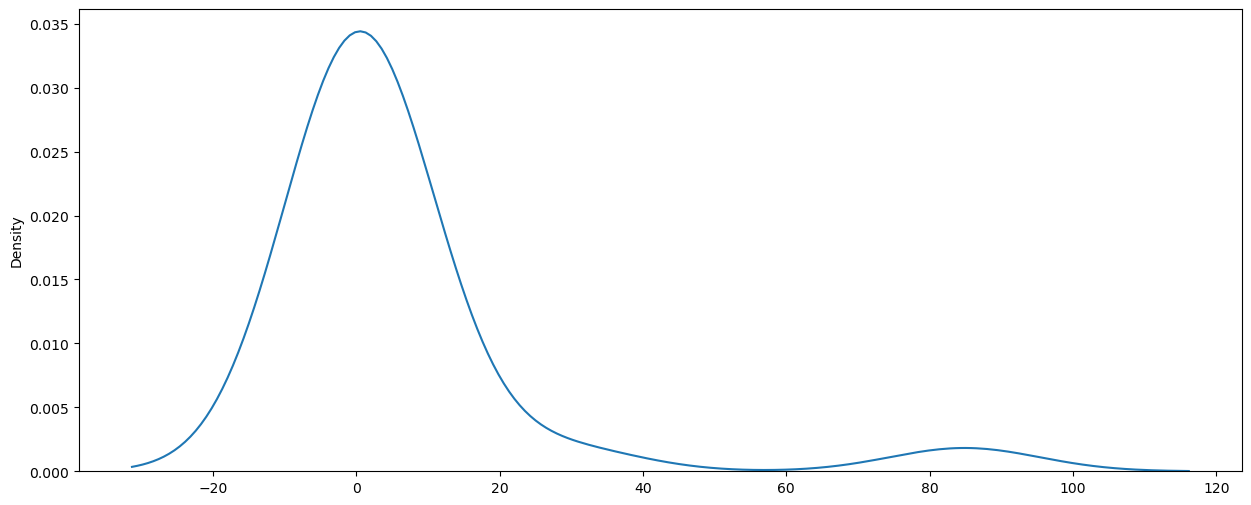

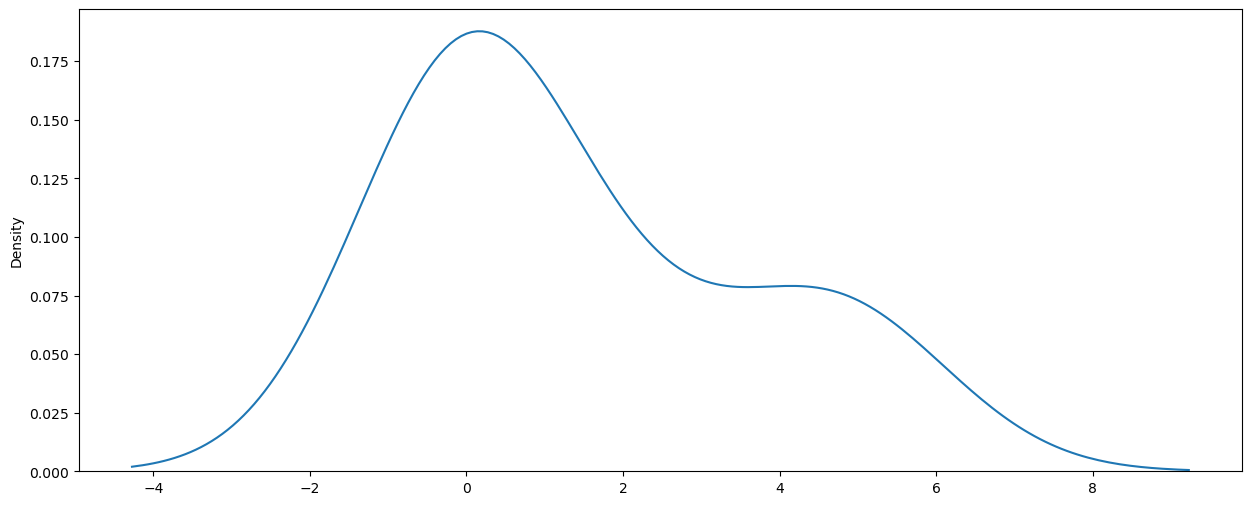

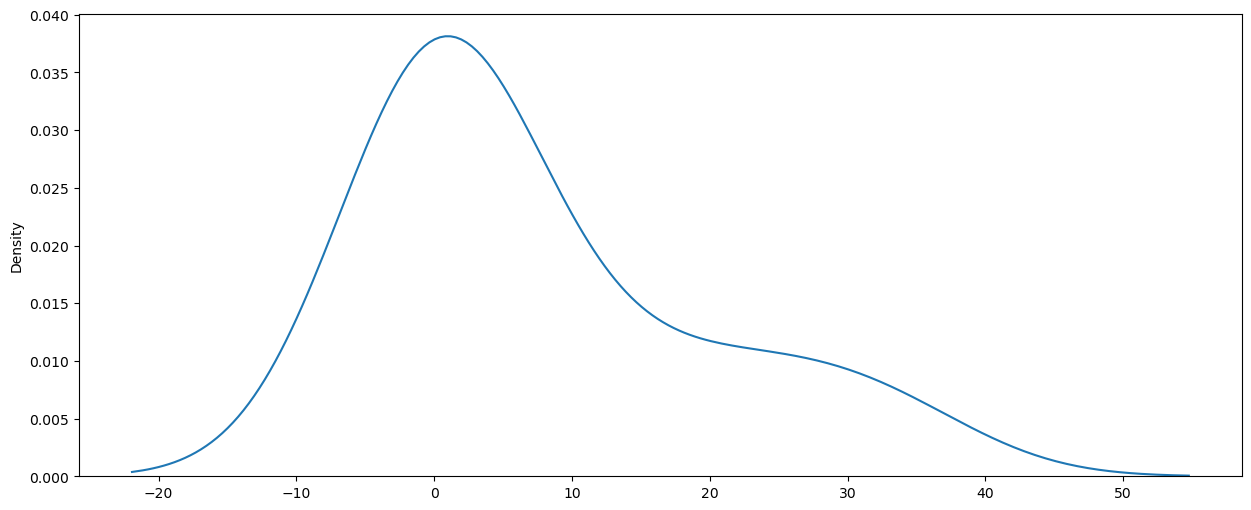

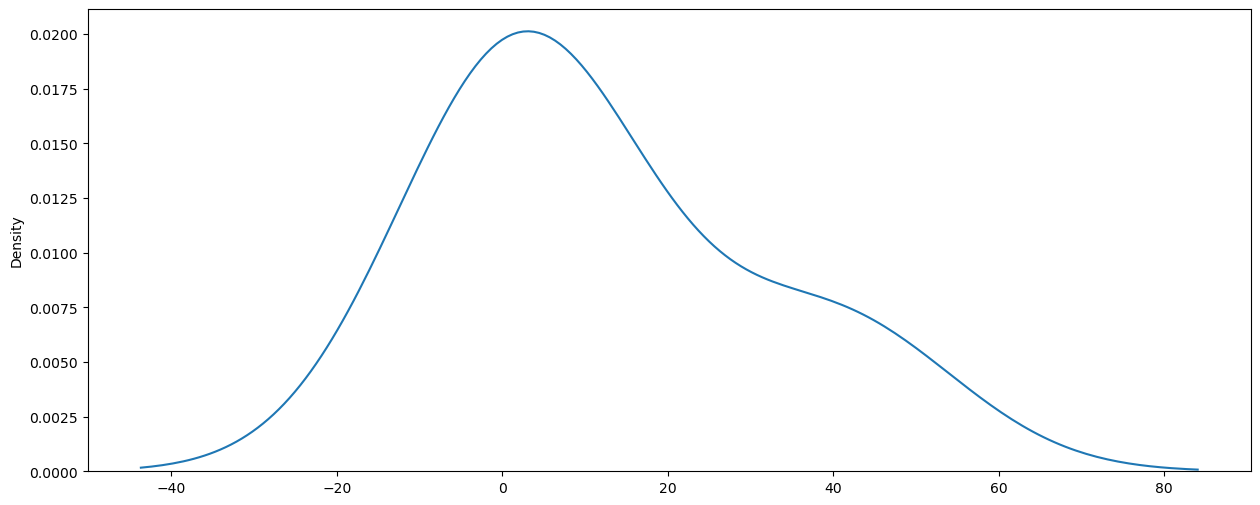

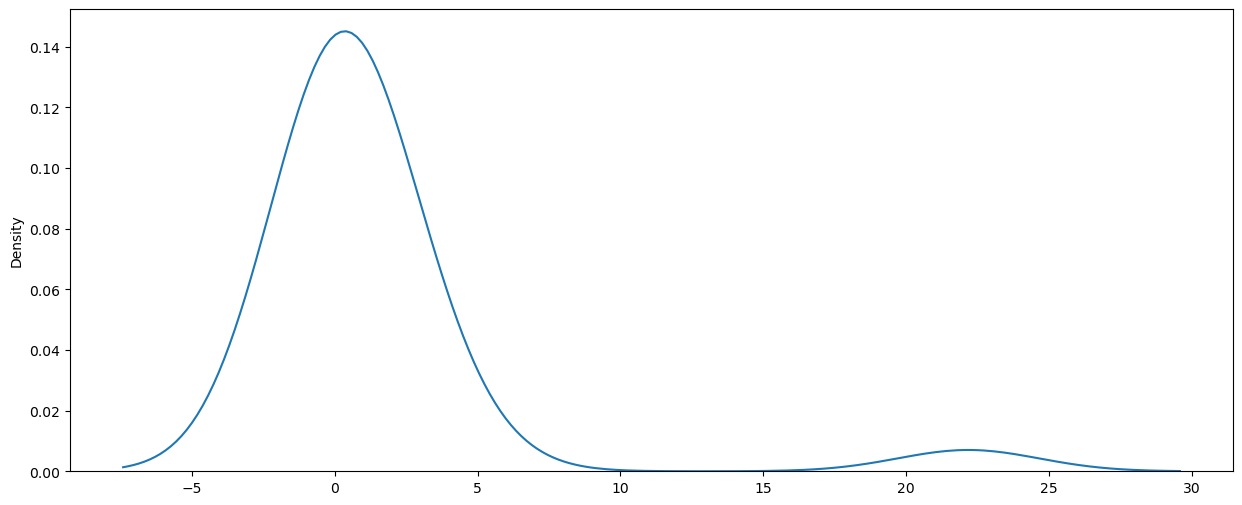

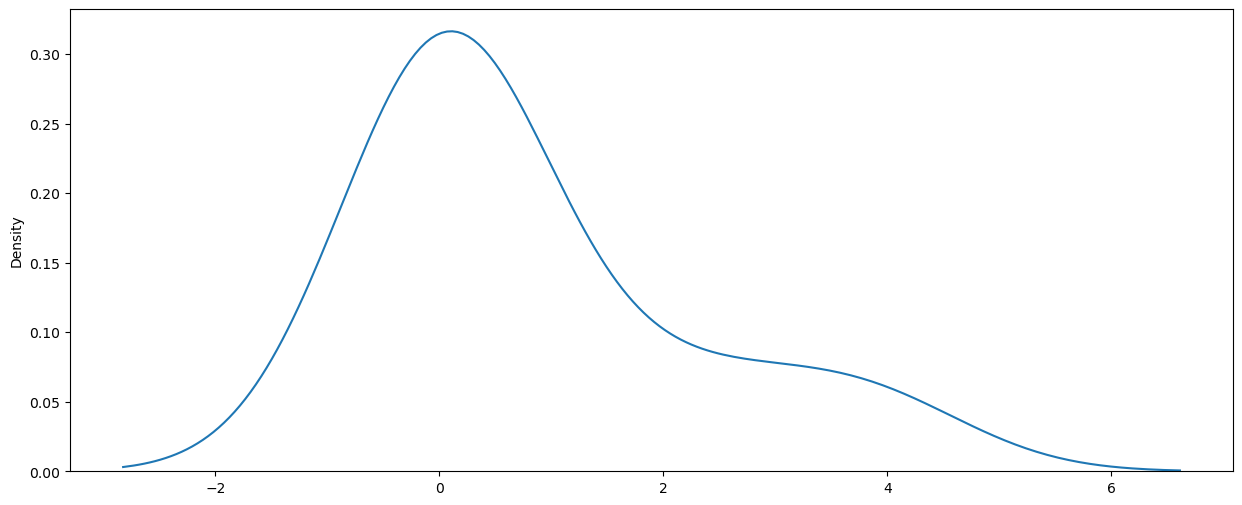

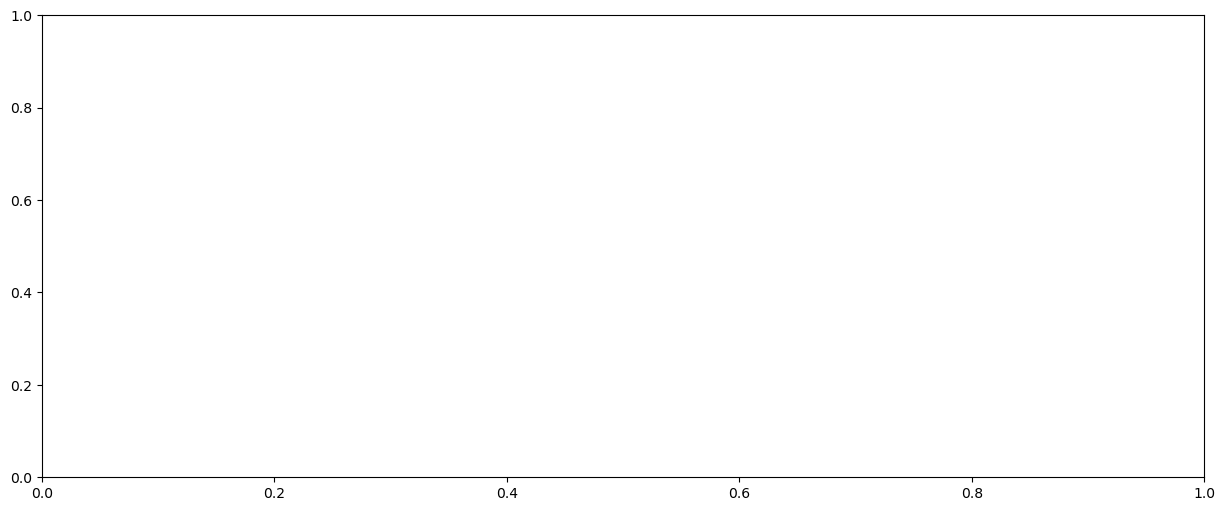

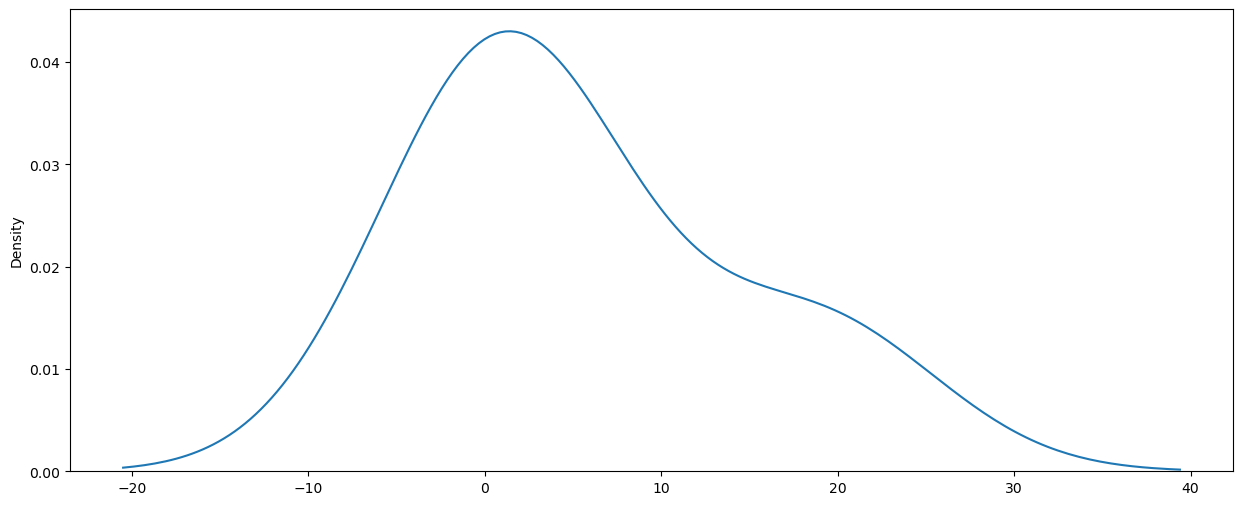

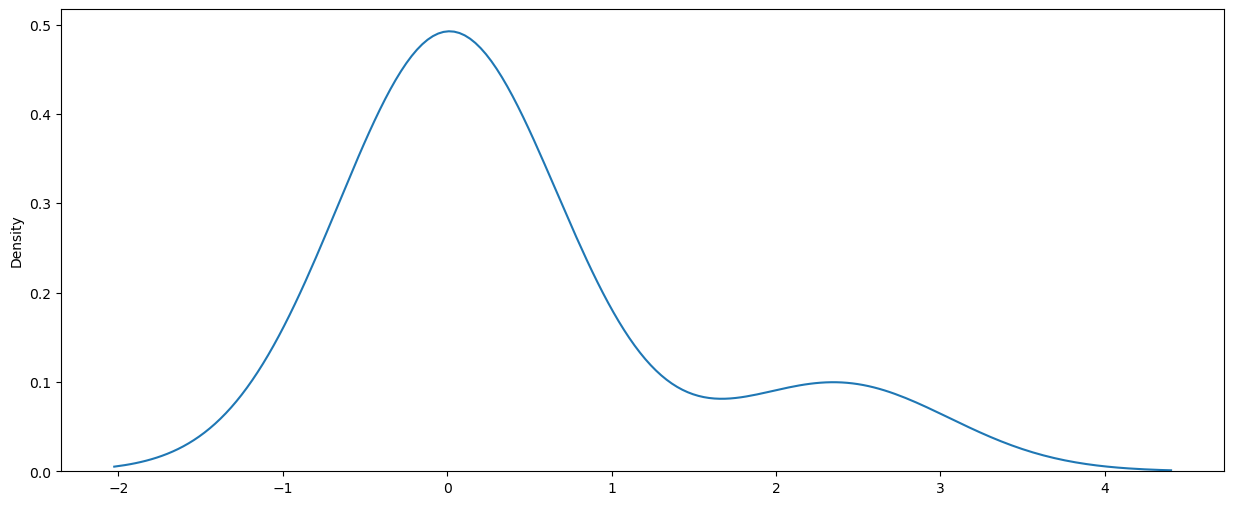

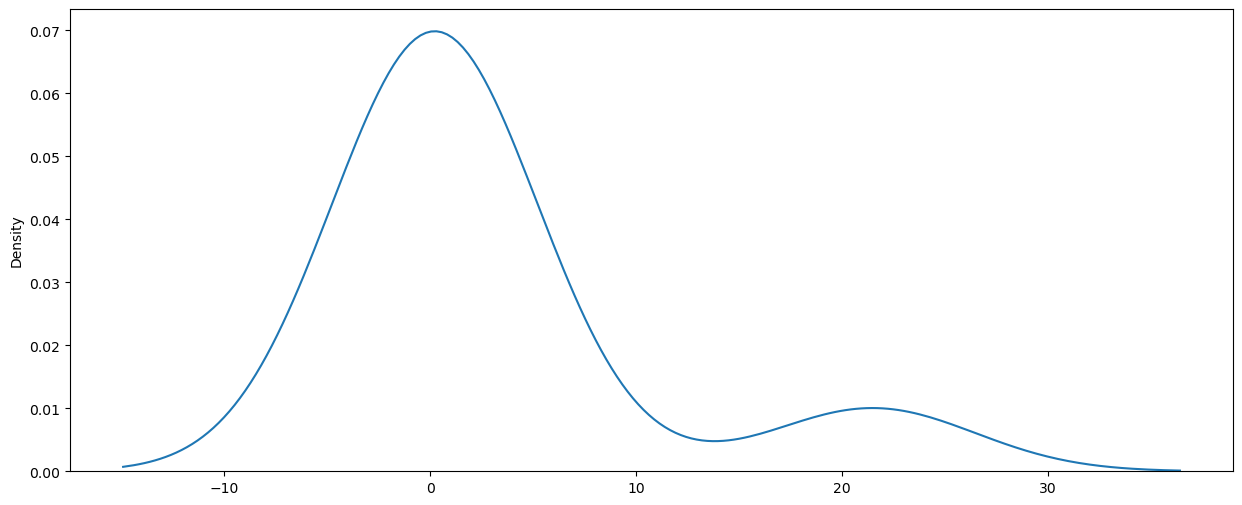

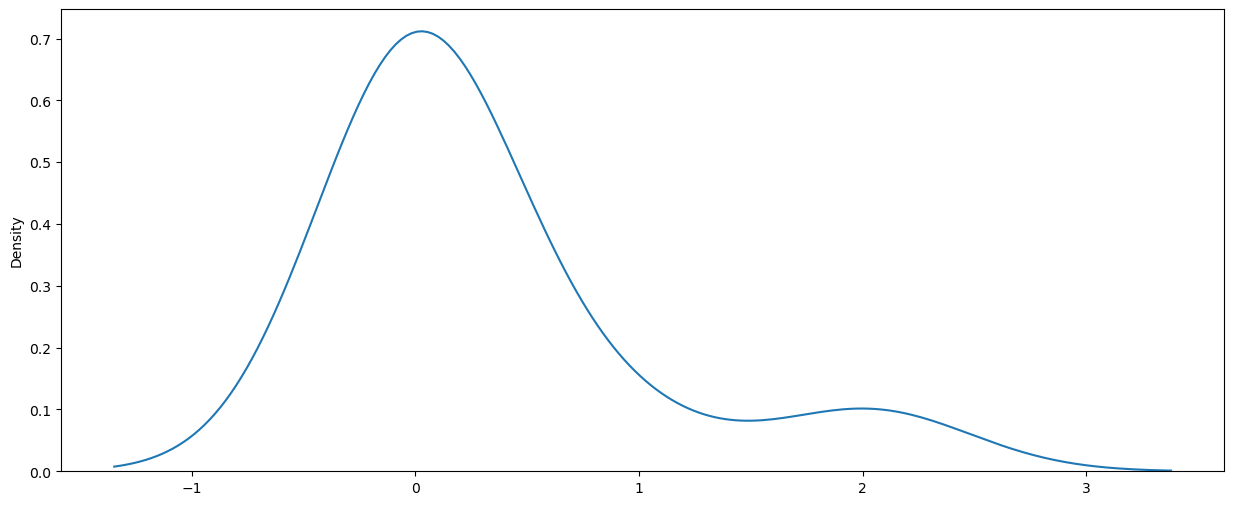

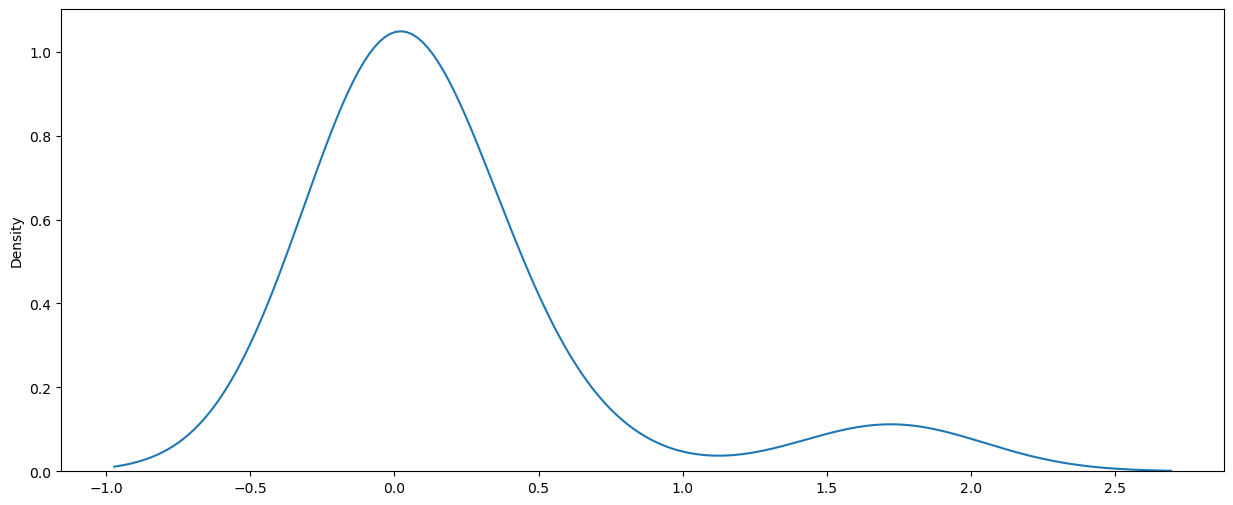

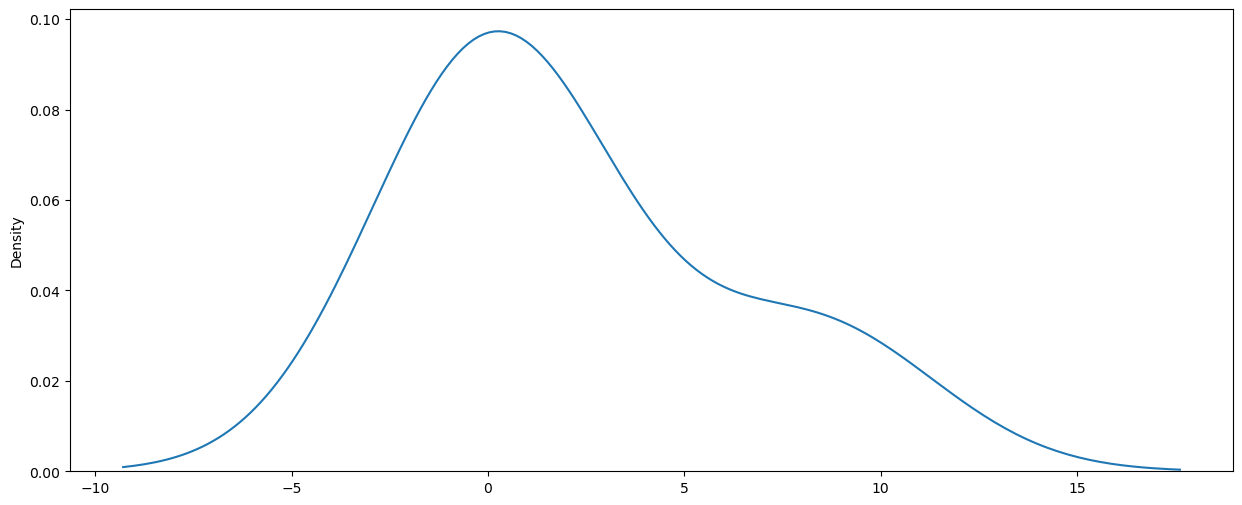

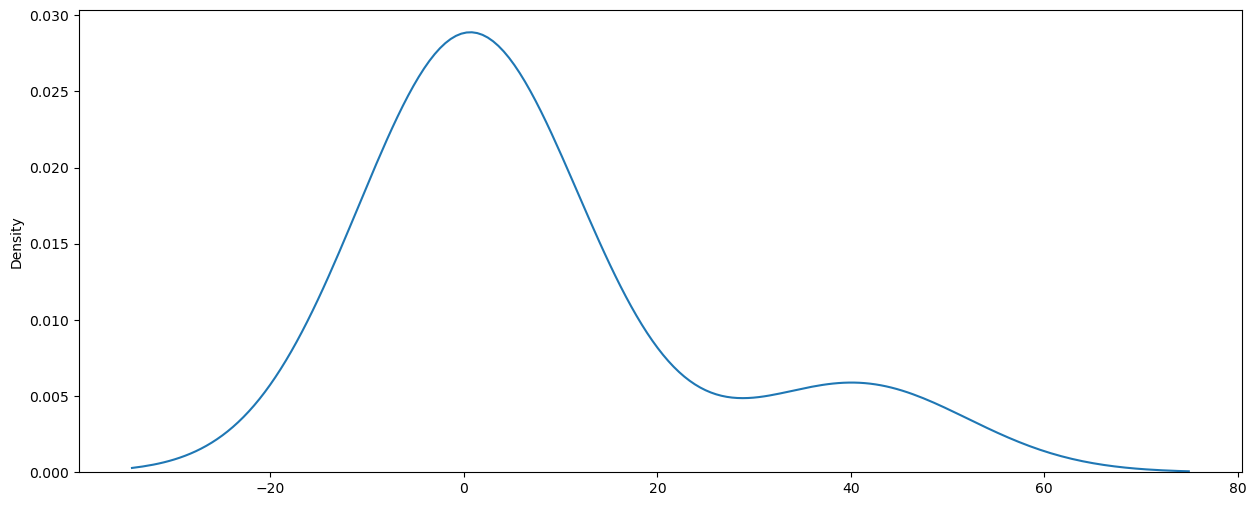

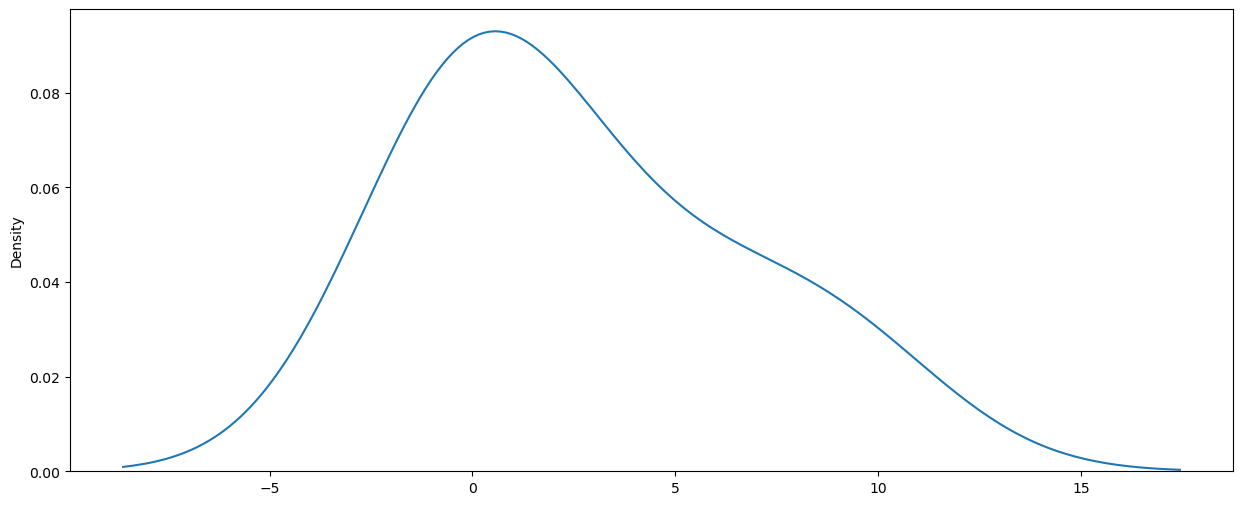

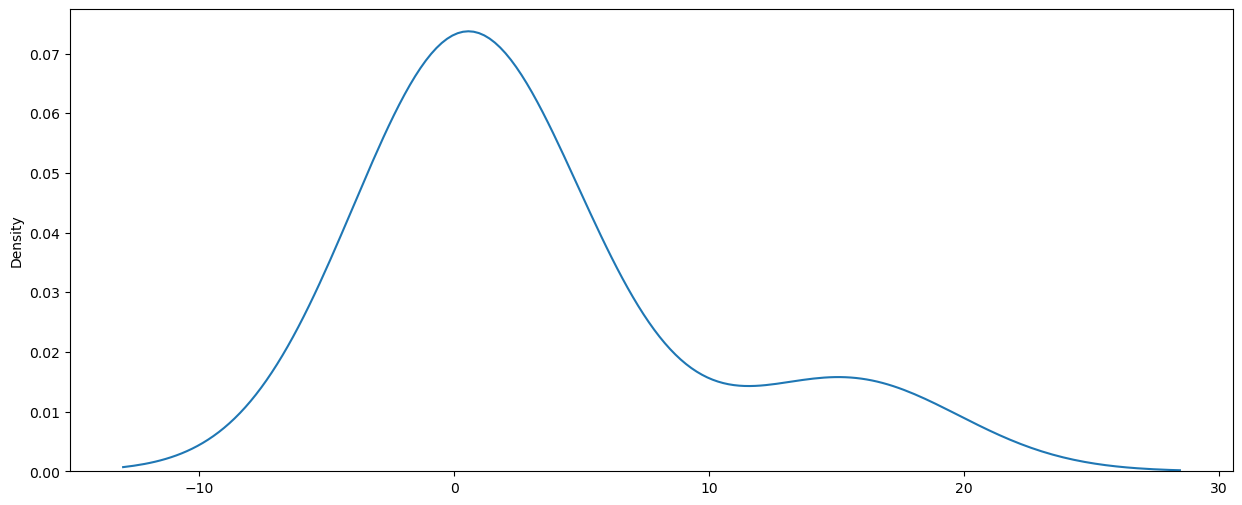

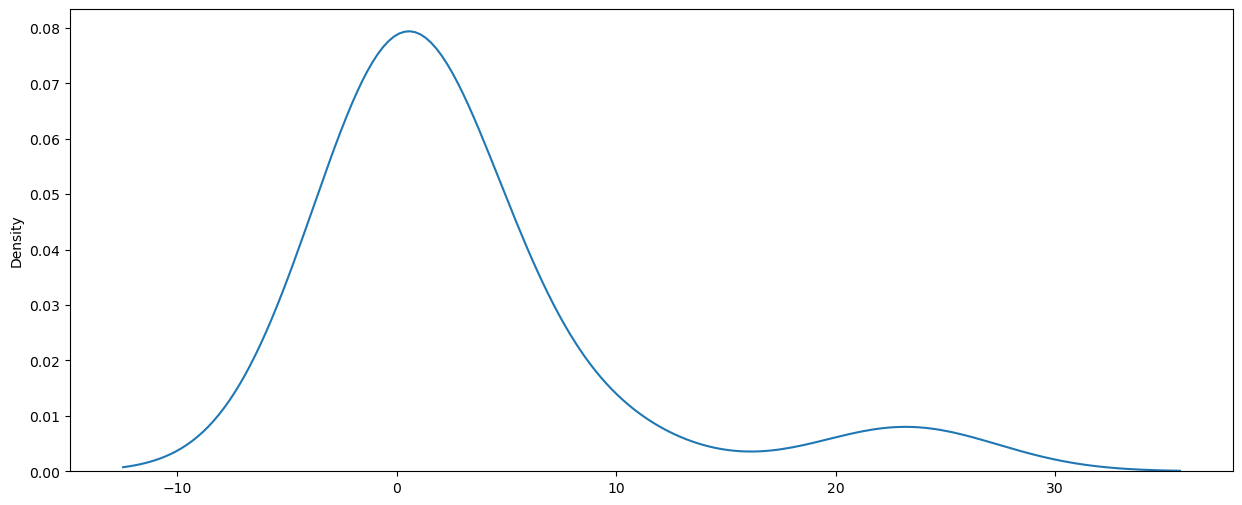

In [77]:
import seaborn as sns
from scipy.stats import ks_2samp
import numpy as np
for i in range(2002,2019):
    try:
        fig1,ax = plt.subplots(figsize = (15,6))
        sns.distplot(lagdf.groupby(lagdf.index.year)['lag2'].apply(list)[i],hist=False,ax=ax)

#         ax1=ax.twinx()
#         sns.distplot(lagdf.groupby(lagdf.index.year)['batch'].apply(list)[i],hist=False,ax=ax1)
        print(ks_2samp(lagdf.groupby(lagdf.index.year)['lag3'].apply(list)[i],lagdf.groupby(lagdf.index.year)['batch'].apply(list)[i]))
    except:
        print(i)


<AxesSubplot:>

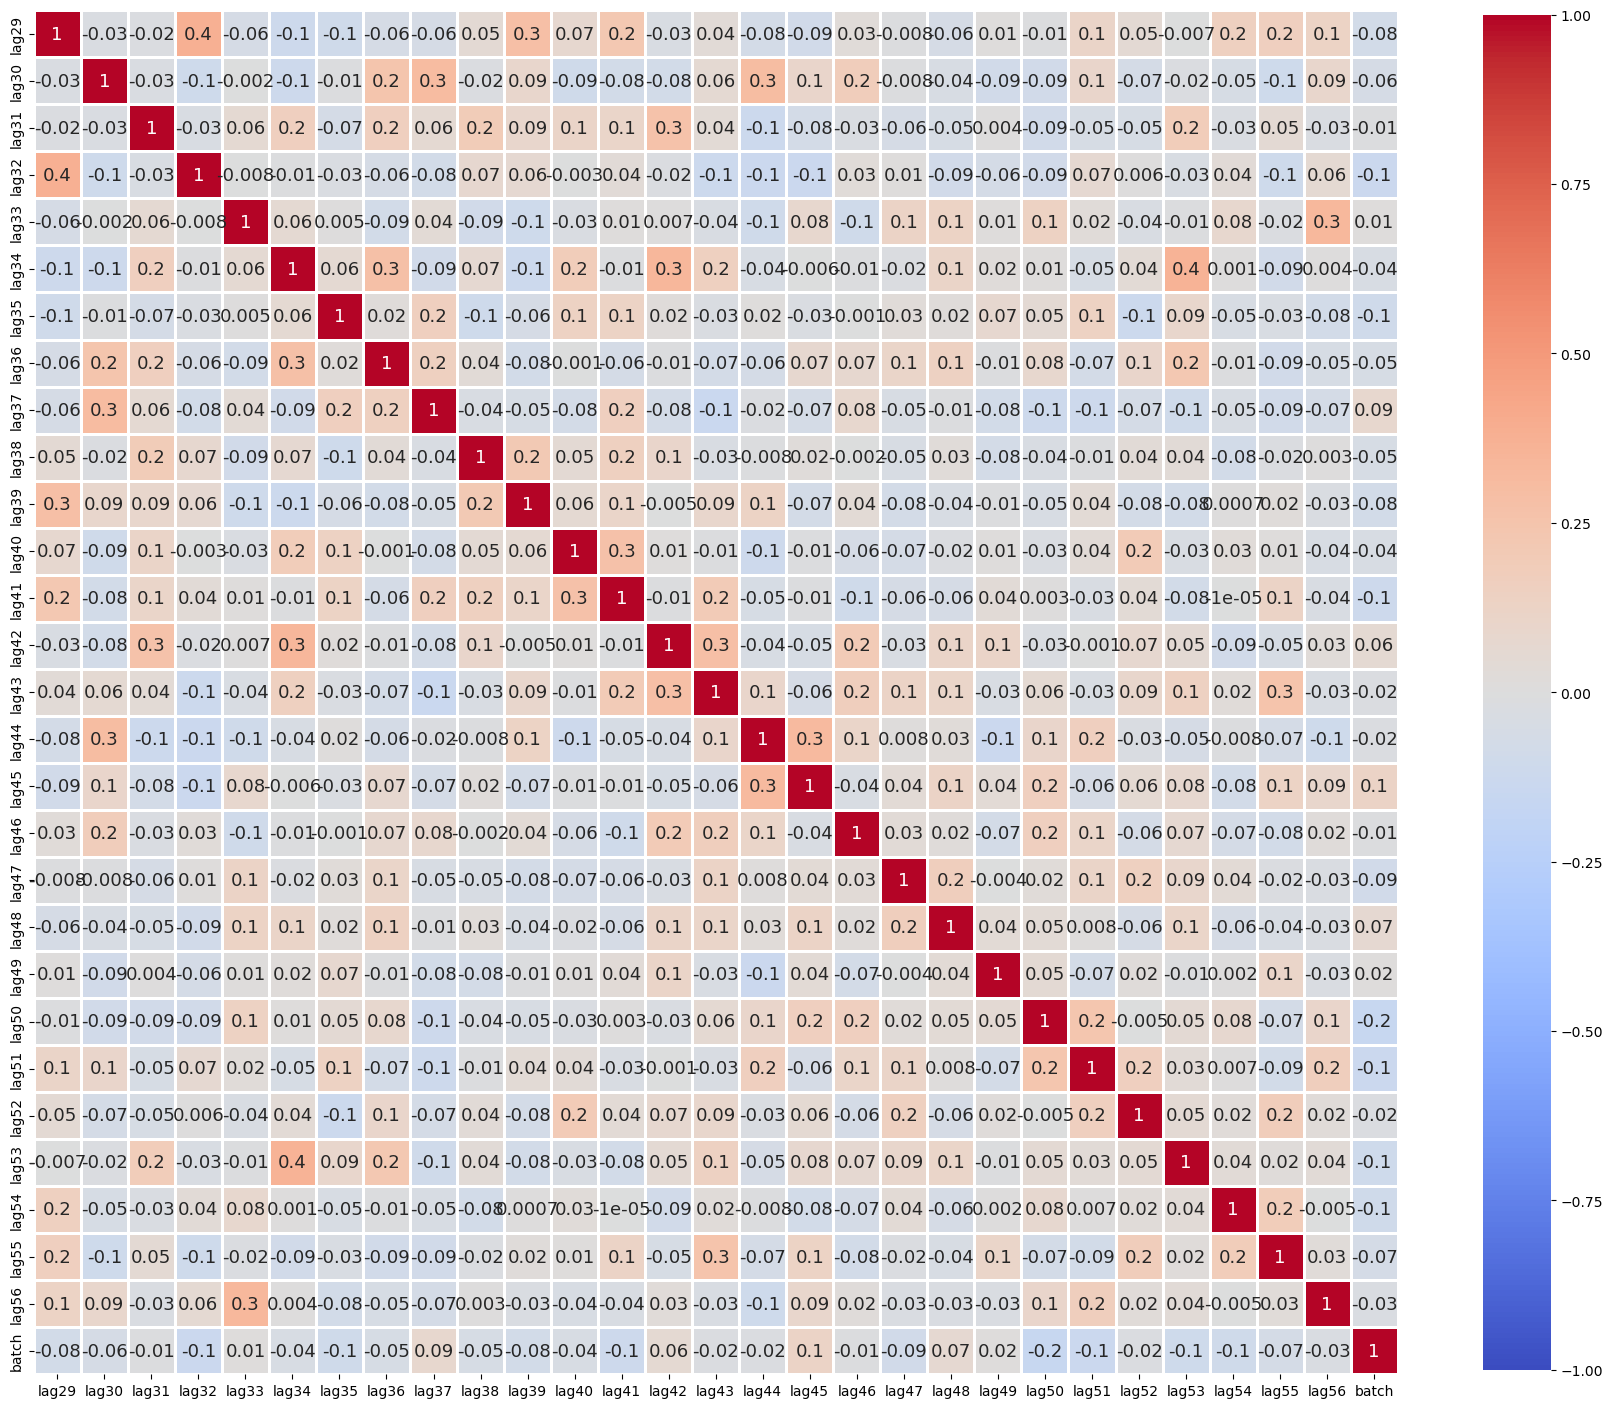

In [34]:
from matplotlib.pyplot import figure
figure(figsize=(22,22))
sns.heatmap(lagdf.corr(), cmap='coolwarm',vmin=-1, vmax=1,
                     square=True, linewidth=1,annot=True,annot_kws={'size':'13'},
                     cbar_kws={"shrink": 0.8}, fmt='.1g',center=0)

<AxesSubplot:>

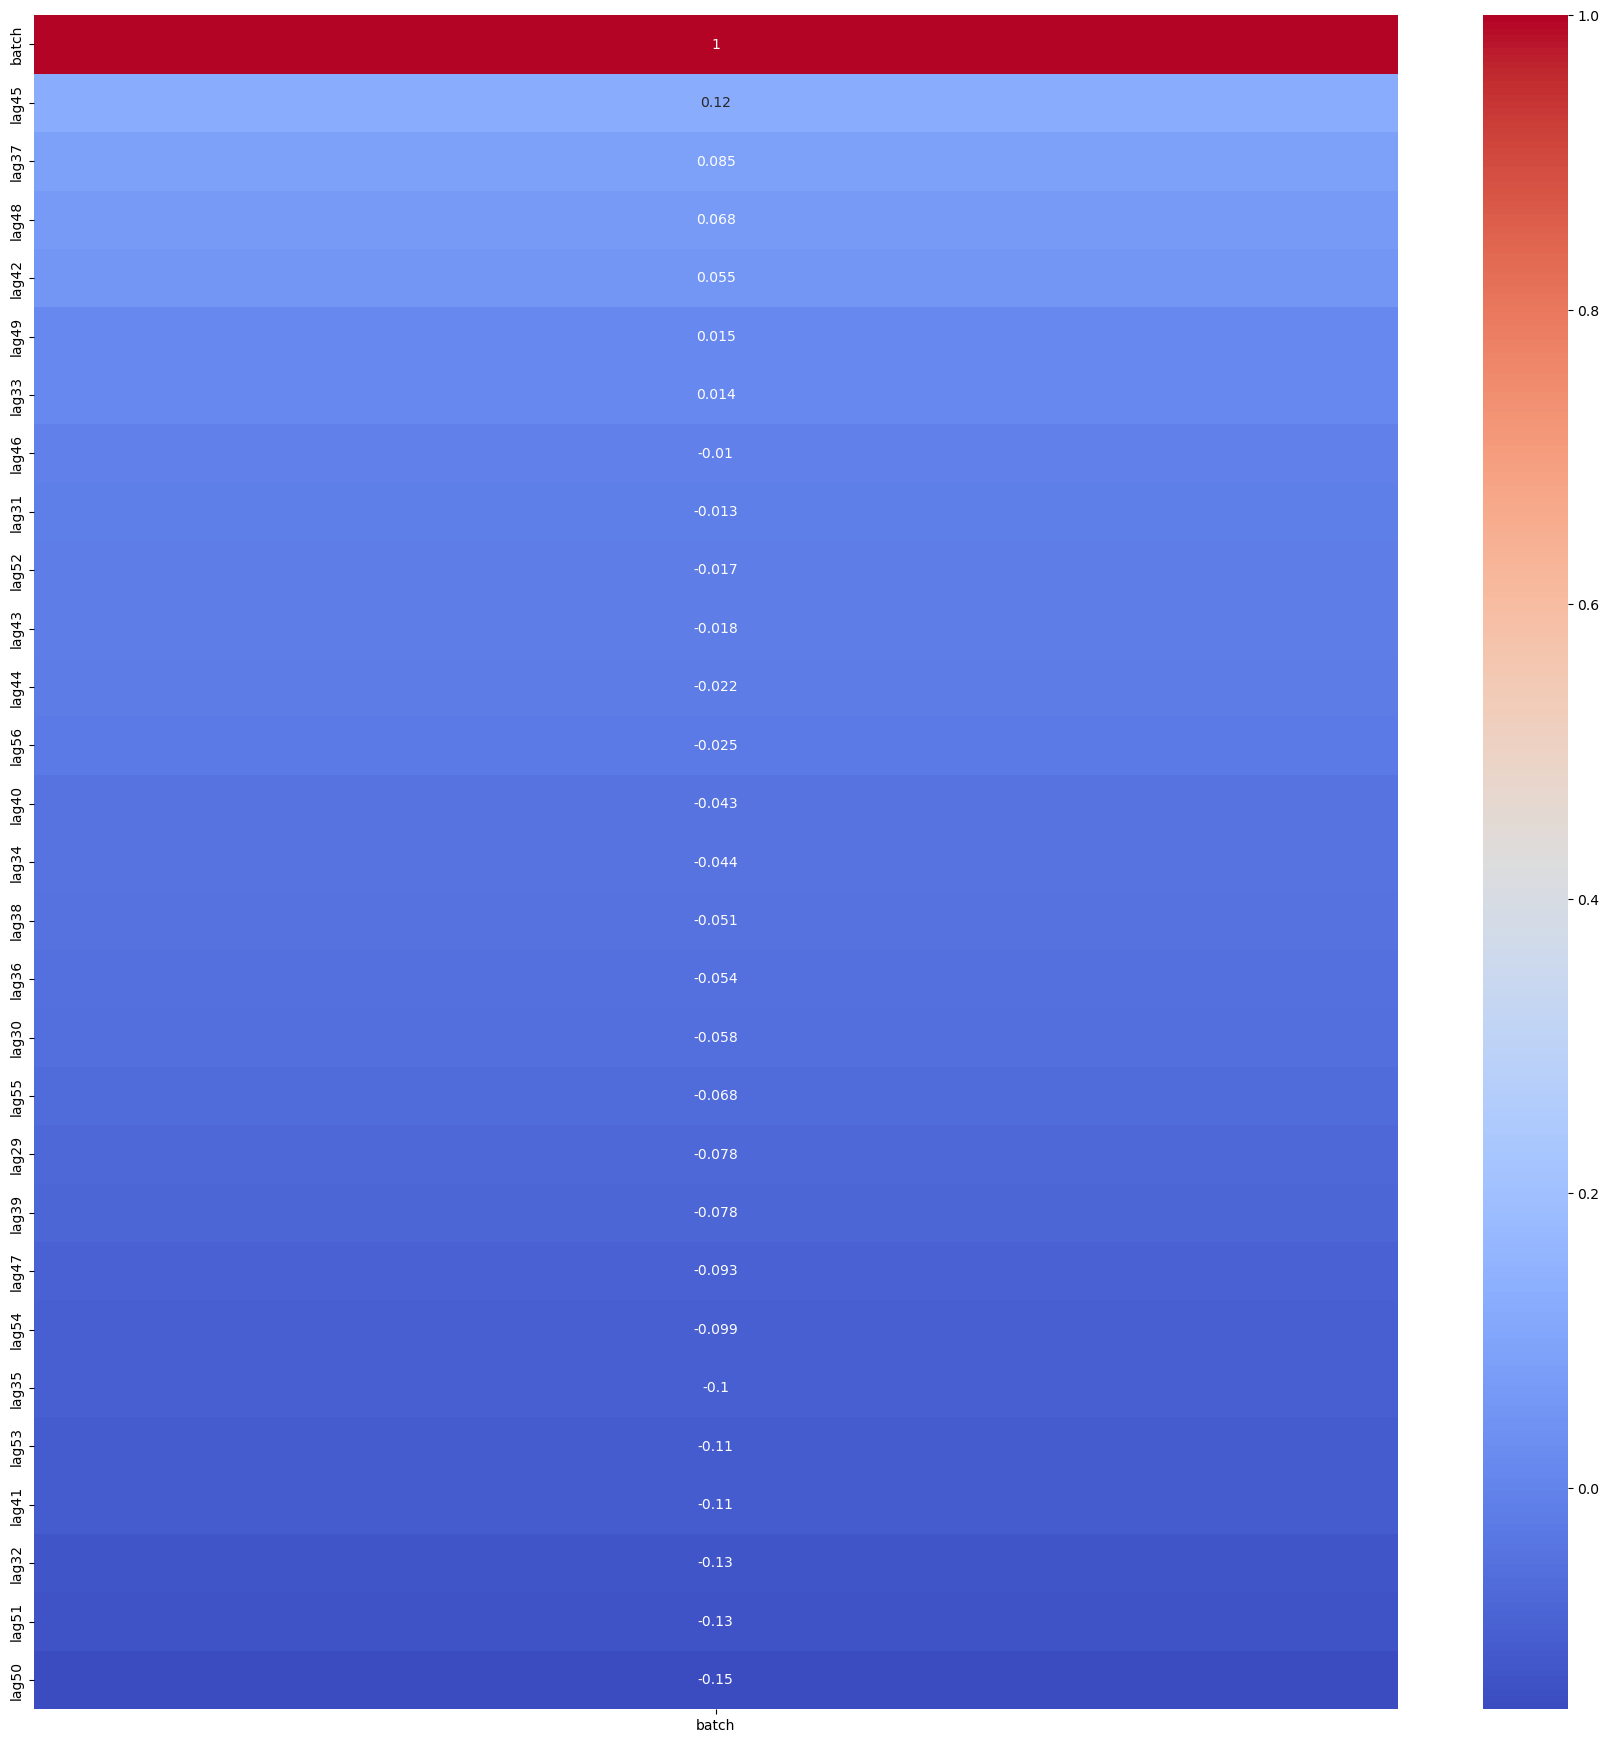

In [35]:
import seaborn as sns
corr = lagdf.corr()[['batch']].sort_values(ascending=False, by='batch')
plt.figure(figsize=(22,22))
sns.heatmap(corr, cmap='coolwarm', annot=True, vmax=1)

In [36]:
for i in range(2,len(lagdf.columns)):
    lagdf['pptaccum-'+str(i+27-1)] = lagdf[lagdf.columns[:i]].sum(axis=1)

<AxesSubplot:>

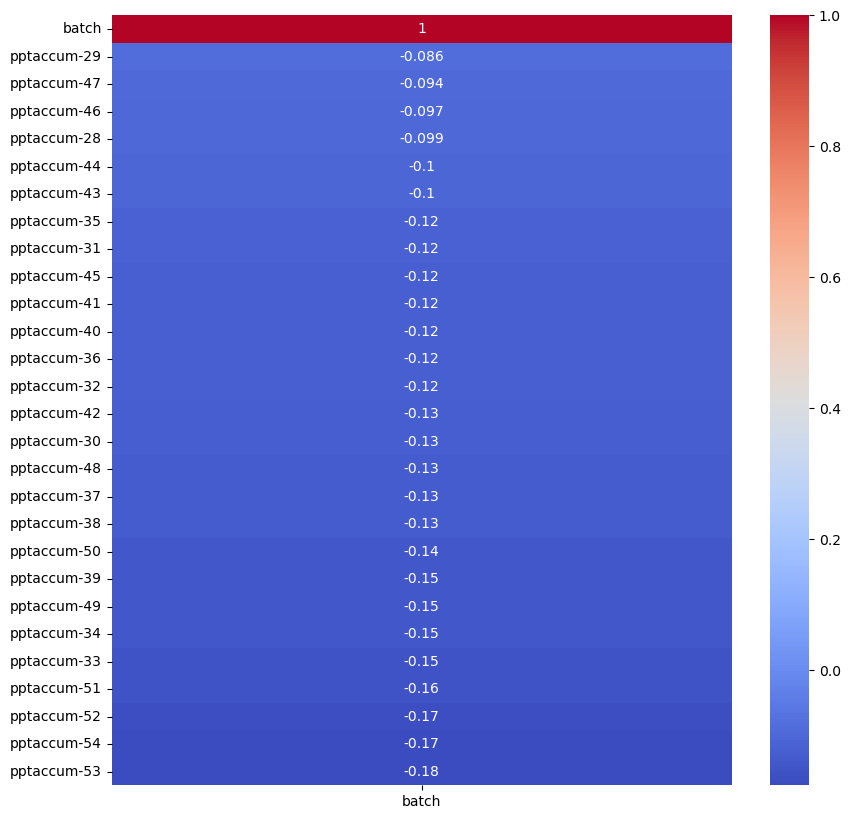

In [37]:
corr1 = lagdf[lagdf.columns[28:]].corr()[['batch']].sort_values(ascending=False, by='batch')
plt.figure(figsize=(10,10))
sns.heatmap(corr1, cmap='coolwarm', annot=True, vmax=1)

In [114]:
for i in range(2,28):    
    lagdf['pptweighted-'+str(i+1)] = sum(map(np.array,[lagdf[lagdf.columns[j]]*(i+1) for j in range(0,i)]))

<AxesSubplot:>

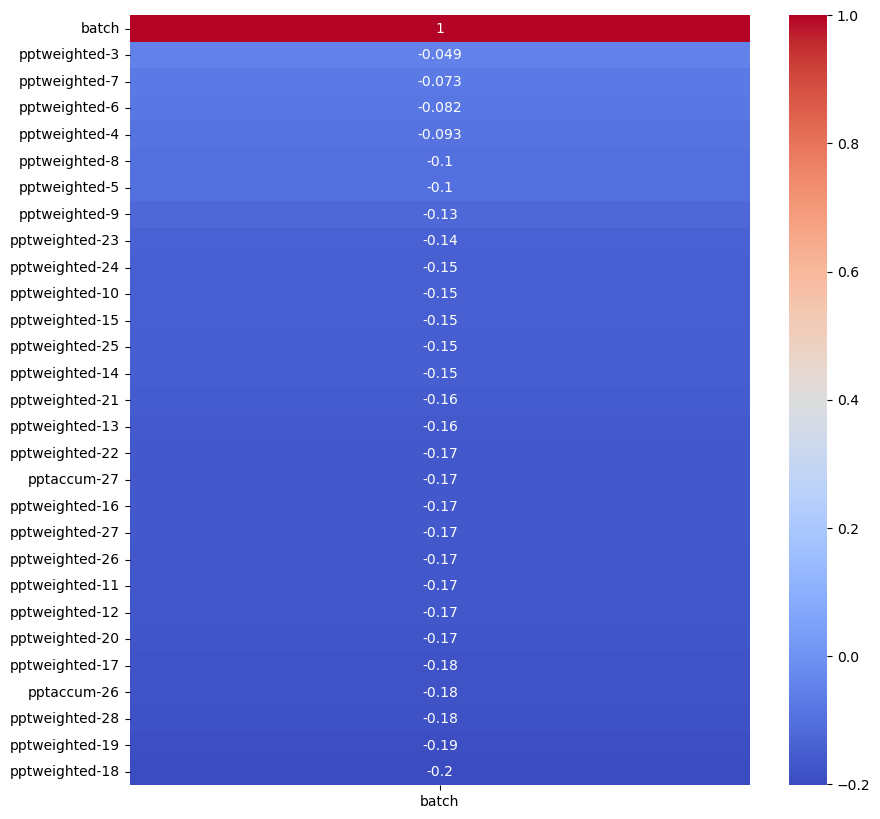

In [115]:

corr2 = lagdf[['batch',*lagdf.columns[-28:]]].corr()[['batch']].sort_values(ascending=False, by='batch')
plt.figure(figsize=(10,10))
sns.heatmap(corr2, cmap='coolwarm', annot=True, vmax=1)

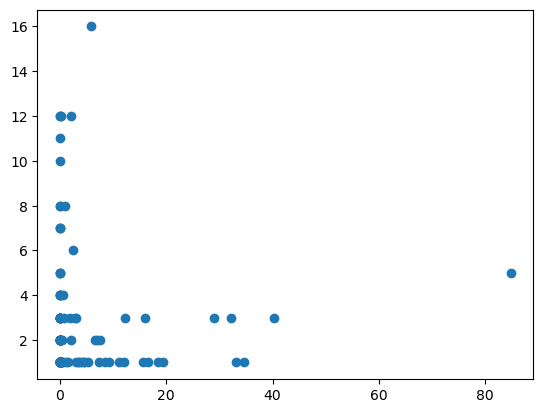

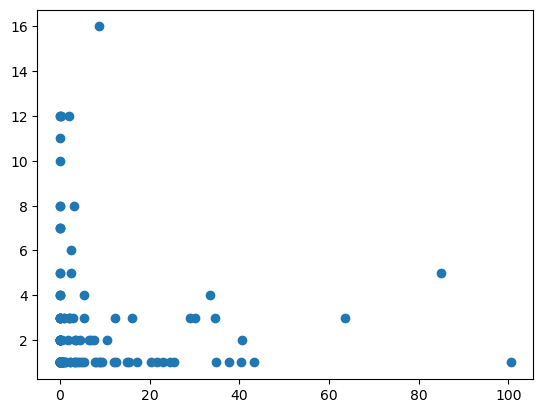

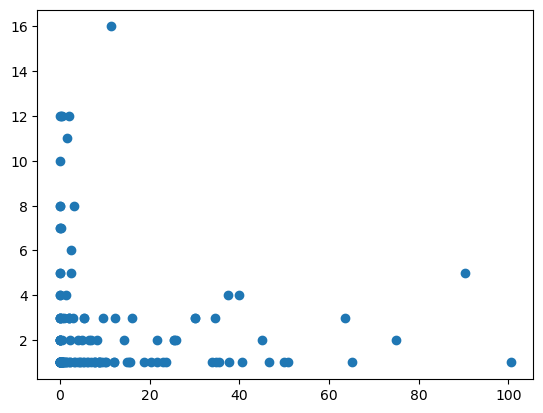

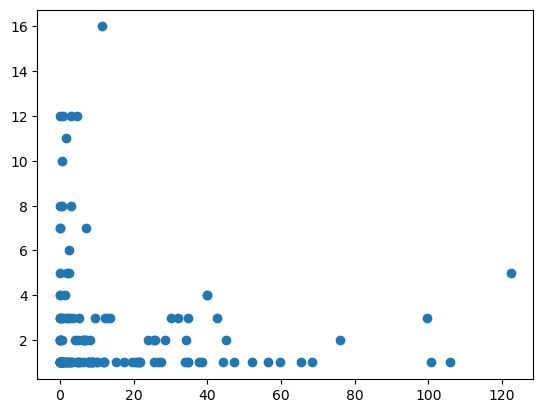

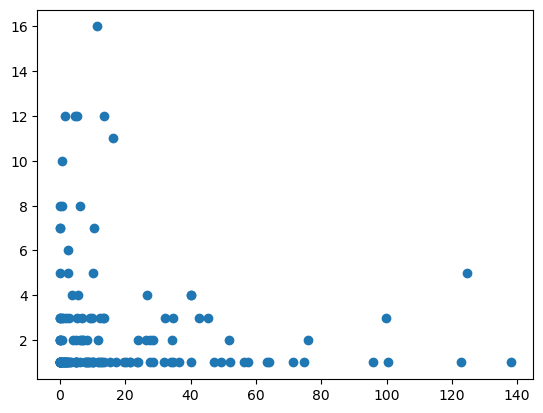

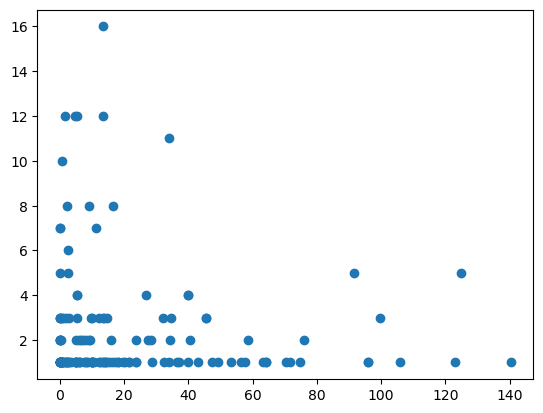

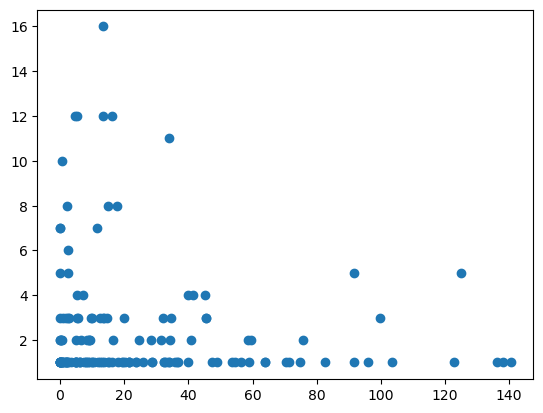

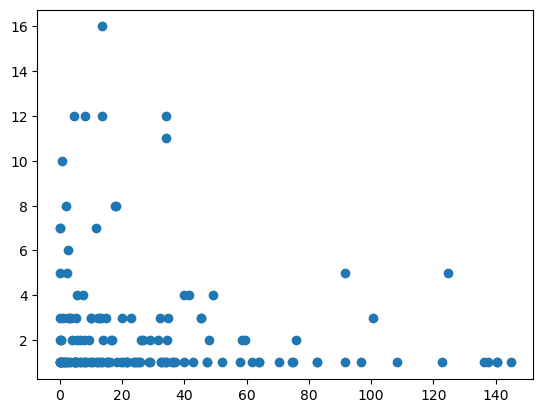

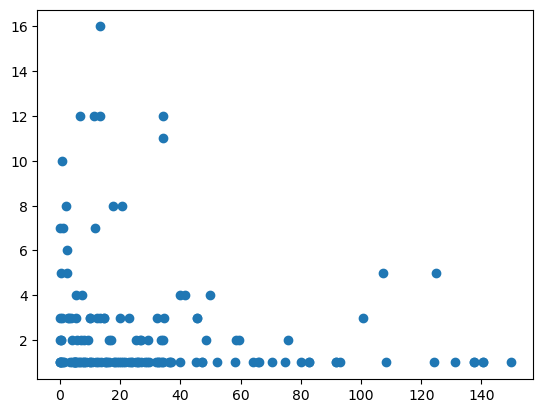

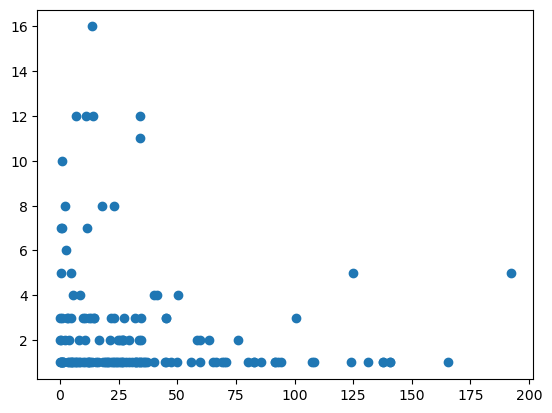

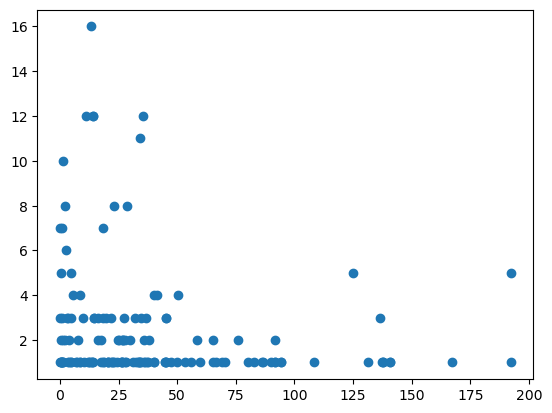

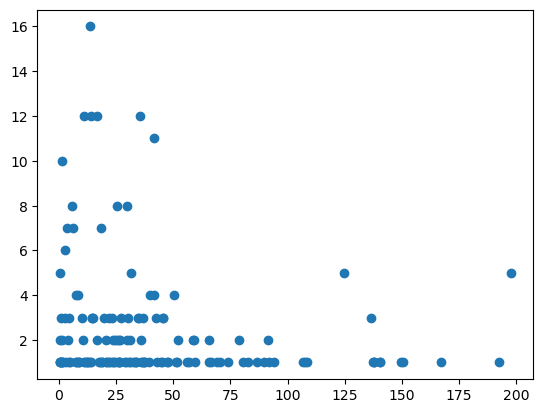

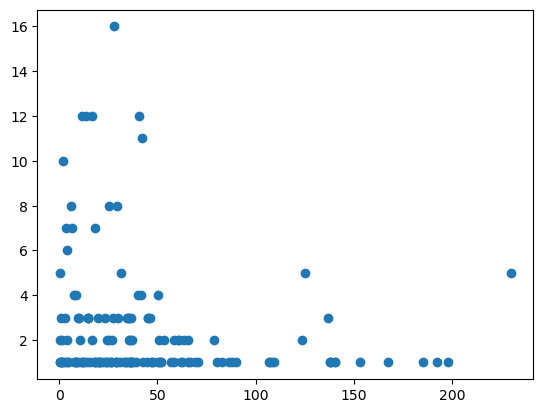

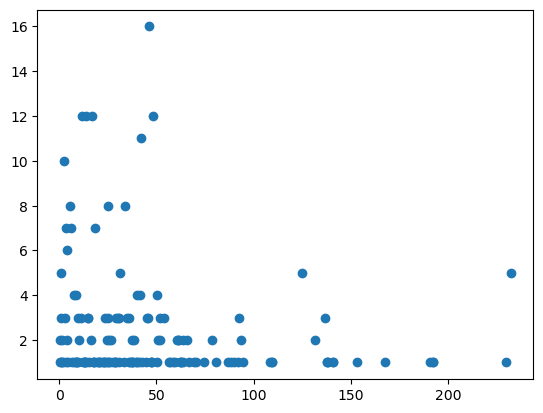

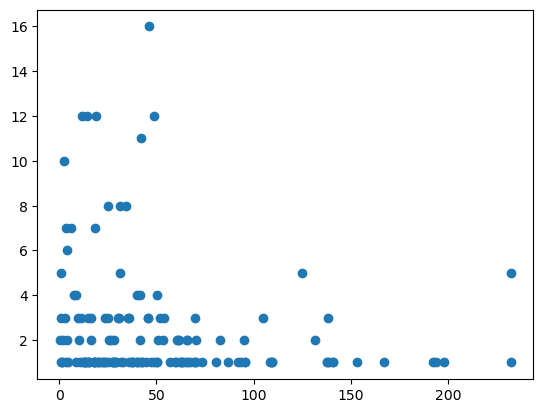

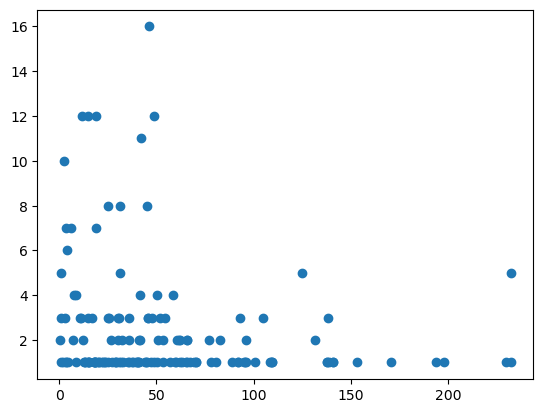

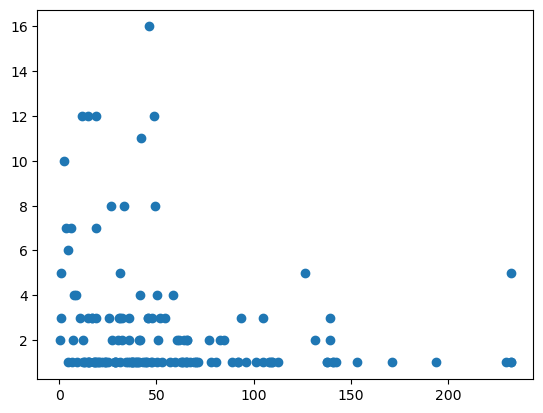

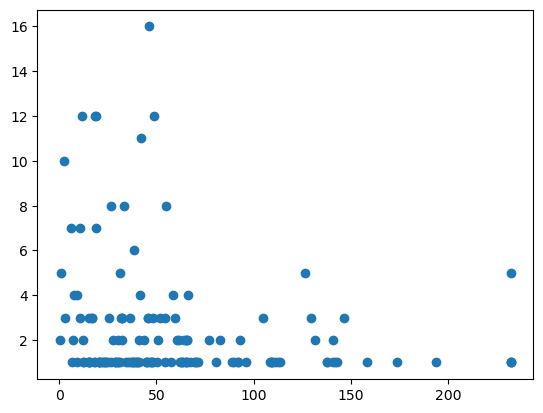

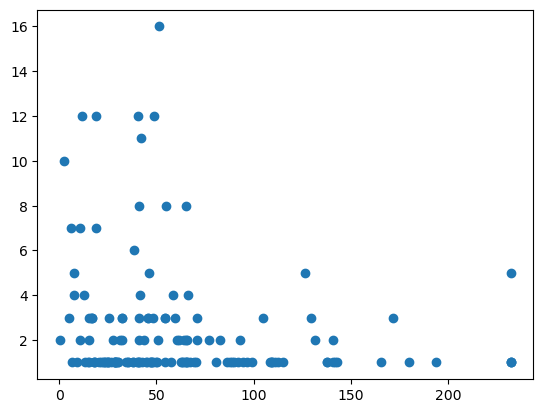

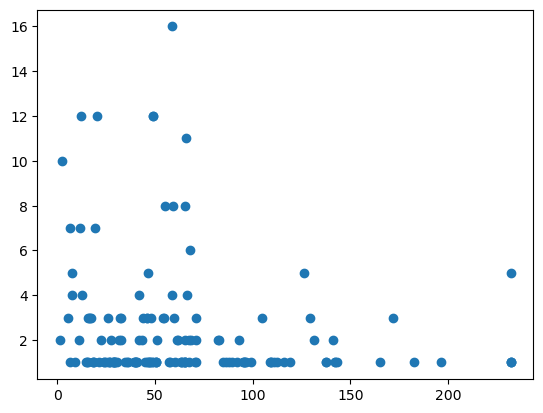

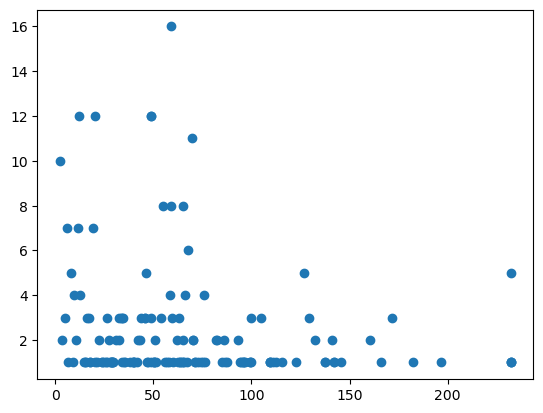

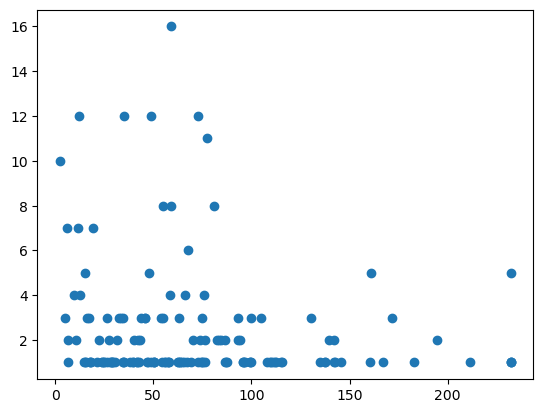

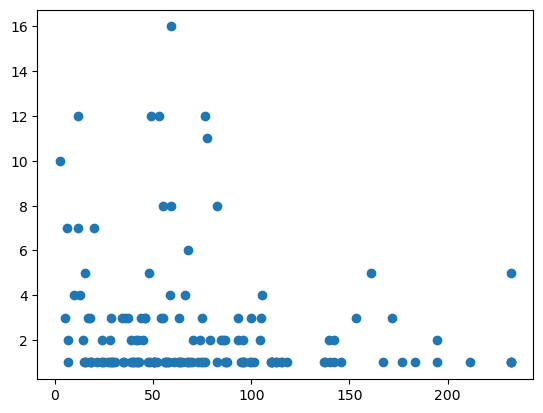

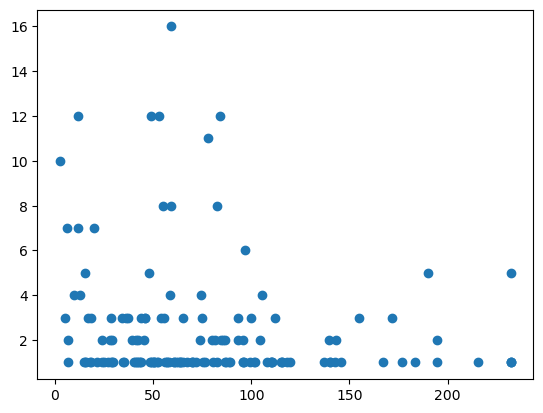

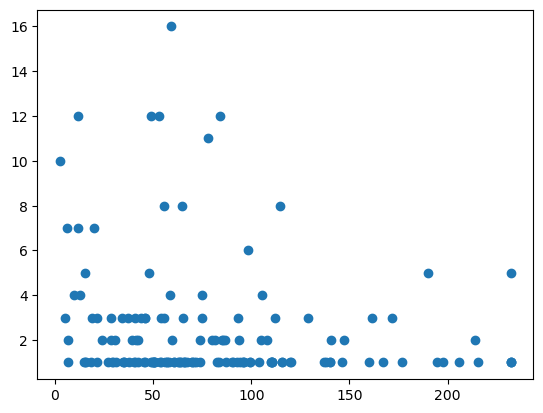

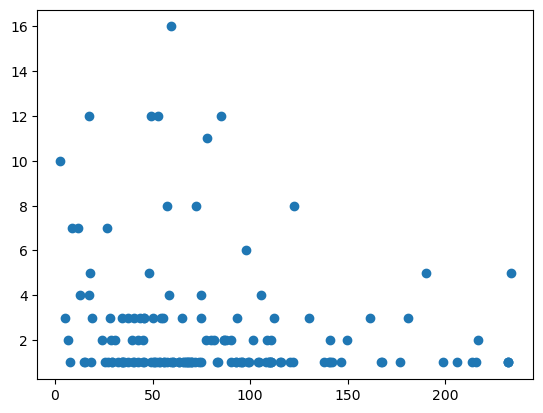

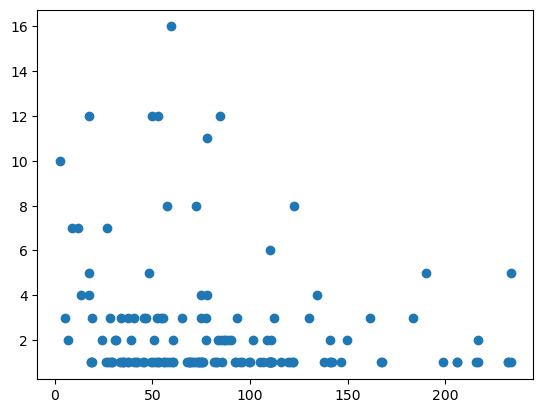

In [55]:
lagdf=lagdf.sort_values('batch')
for i in range(1,len(lagdf.columns)):
    plt.scatter(lagdf[lagdf.columns[:i]].sum(axis=1),lagdf.index)
    plt.show()

# Bucket data analysis

In [11]:
#Bucket locations
bucket = pd.read_excel('/data/dhence/a/pborse2/inputdata/Mosquito data/bucket Locations.xlsx')
champbuck = fiopen['tp'].sel(x=slice(734.5,736.5),y=slice(488,490.5)).mean(('x','y')) # Area spanned by bucket locations in further analysis

In [12]:
locs = bucket.head(2)

In [13]:
bucket.drop(index=bucket.index[:2],inplace=True)

In [14]:
bucket =  bucket.replace(regex='([a-zA-Z])', value=0).fillna(0)

In [15]:
bucket.set_index('DATE',inplace=True)

In [16]:
locs=locs.rename(columns={'DATE':'latlon'})
locs.set_index('latlon',inplace=True)

In [17]:
locs = locs.replace('– 40.054373', -40.054373)
locs=locs.T

In [18]:

xbuck = [hrap_from_latlon(-locs.iloc[i]['Lat'],locs.iloc[i]['Lon'])[0] for i in range(len(locs.index))]
ybuck=  [hrap_from_latlon(-locs.iloc[i]['Lat'],locs.iloc[i]['Lon'])[1] for i in range(len(locs.index))]
locs['Lon'] = xbuck
locs['Lat']= ybuck

geombuck = gpd.points_from_xy(xbuck, ybuck)
buckgpd = gpd.GeoDataFrame(locs, geometry=geombuck, crs = crs_proj4 )


In [19]:
bucket['sum'] = bucket.sum(axis=1)

In [21]:
bucket['sum'][1]

3.0

In [20]:
buckgpd['% lar']= [bucket[i].sum()*100/bucket['sum'].sum() for i in buckgpd.index]

In [23]:
for i in range(len(bucket)):
    buckgpd['lar-'+str(i)] = [bucket[j][i]*100/bucket['sum'][i] for j in buckgpd.index]

/tmp/ipykernel_92600/3225844490.py:2: RuntimeWarning: invalid value encountered in double_scalars
  buckgpd['lar-'+str(i)] = [bucket[j][i]*100/bucket['sum'][i] for j in buckgpd.index]
/data/keeling/a/pborse2/miniconda39/envs/geonew/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/data/keeling/a/pborse2/miniconda39/envs/geonew/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().

In [24]:
buckgpd.mean(axis=1)

/tmp/ipykernel_92600/586540807.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  buckgpd.mean(axis=1)


SAVOY         15.346586
NOVAK         15.223325
CLAYTON       13.906158
FH            17.611929
NATURE        10.765622
LAKE          10.470910
UPW           20.867416
NEVADA        18.527593
BONEYARD      15.435418
WILLIAM       23.744707
PLANTATION    10.773134
CU            12.837940
PIG           15.659486
IVY           18.349797
WINDSOR       10.904875
SCHUH         12.192053
dtype: float64

# Correlation analysis

In [21]:
s=-1
for i in bucket.columns:
    s=s+1
    bucket['junjul'] = bucket[bucket.index.month.isin([6,7])][i]
    bucket['augsep'] = bucket[bucket.index.month.isin([8,9])][i]
    junjul = bucket[bucket.index.month.isin([6,7])][['junjul']]
    augsep = bucket[bucket.index.month.isin([8,9])][['augsep']]
    sav = champcity.sel(x=buckgpd.iloc[s]['Lon'],y=buckgpd.iloc[s]['Lat'],method='nearest')
    sav = sav.groupby('time.year')[2003]
    for i in range(1,50):
        delt = junjul.index-timedelta(i)
        delt1 = augsep.index-timedelta(i)
        junjul['lag-'+str(i)]=sav[sav.time.dt.date.isin(delt.date)].values
        try:
            augsep['lag-'+str(i)]=list(sav[sav.time.dt.date.isin(delt1.date)].values)
        except:
            augsep['lag-'+str(i)]=list(sav[sav.time.dt.date.isin(delt1.date)].values)+[0]
    for i in range(2,len(junjul.columns)-1):
        junjul['accum-'+str(i)] = junjul[junjul.columns[1:i+1]].sum(axis=1)
        augsep['accum-'+str(i)] = augsep[augsep.columns[1:i+1]].sum(axis=1)
    from matplotlib.pyplot import figure
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(22,22))
    sns.heatmap(junjul.corr()[['junjul']],annot=True,ax=ax1)
    sns.heatmap(augsep.corr()[['augsep']],annot=True,ax=ax2)
    plt.show()

KeyboardInterrupt: 

In [61]:
#     junjul['accum-'+str(i)] = 1/((junjul[junjul.columns[1:i+1]].sum(axis=1))**(0.5) + 1)
#     junjul['lag-'+str(i)]=champbuck[champbuck.time.dt.date.isin(delt.date)].values
#     augsep['lag-'+str(i)]=list(champbuck[champbuck.time.dt.date.isin(delt1.date)].values)+[0]

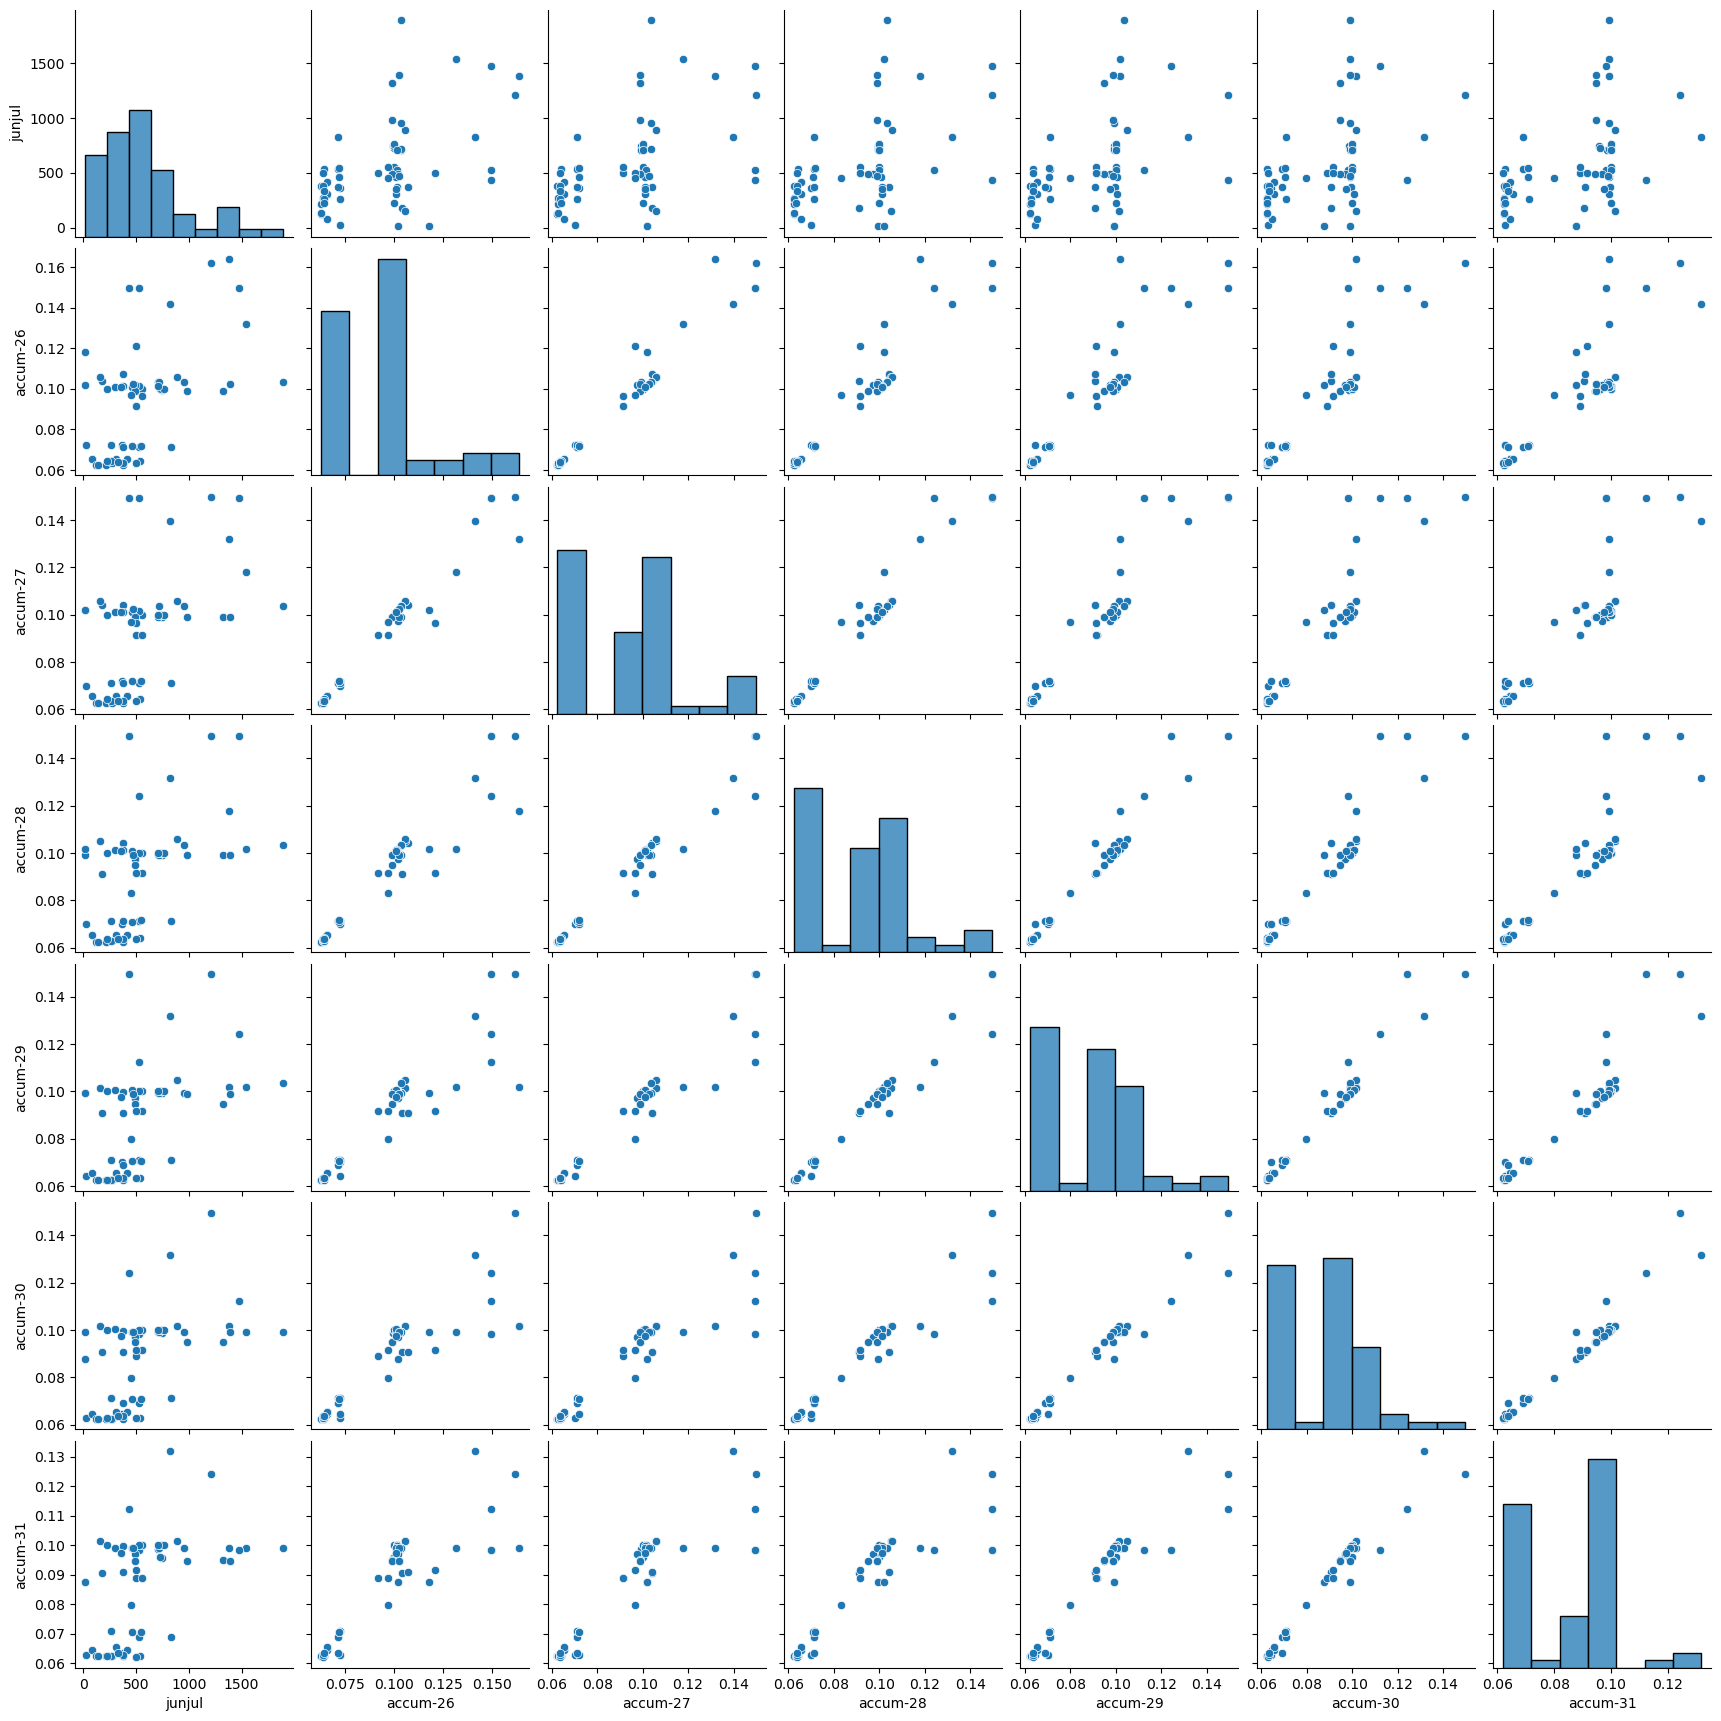

In [75]:
sns.pairplot(junjul[['junjul',*junjul.columns[-9:-3]]])

<AxesSubplot:>

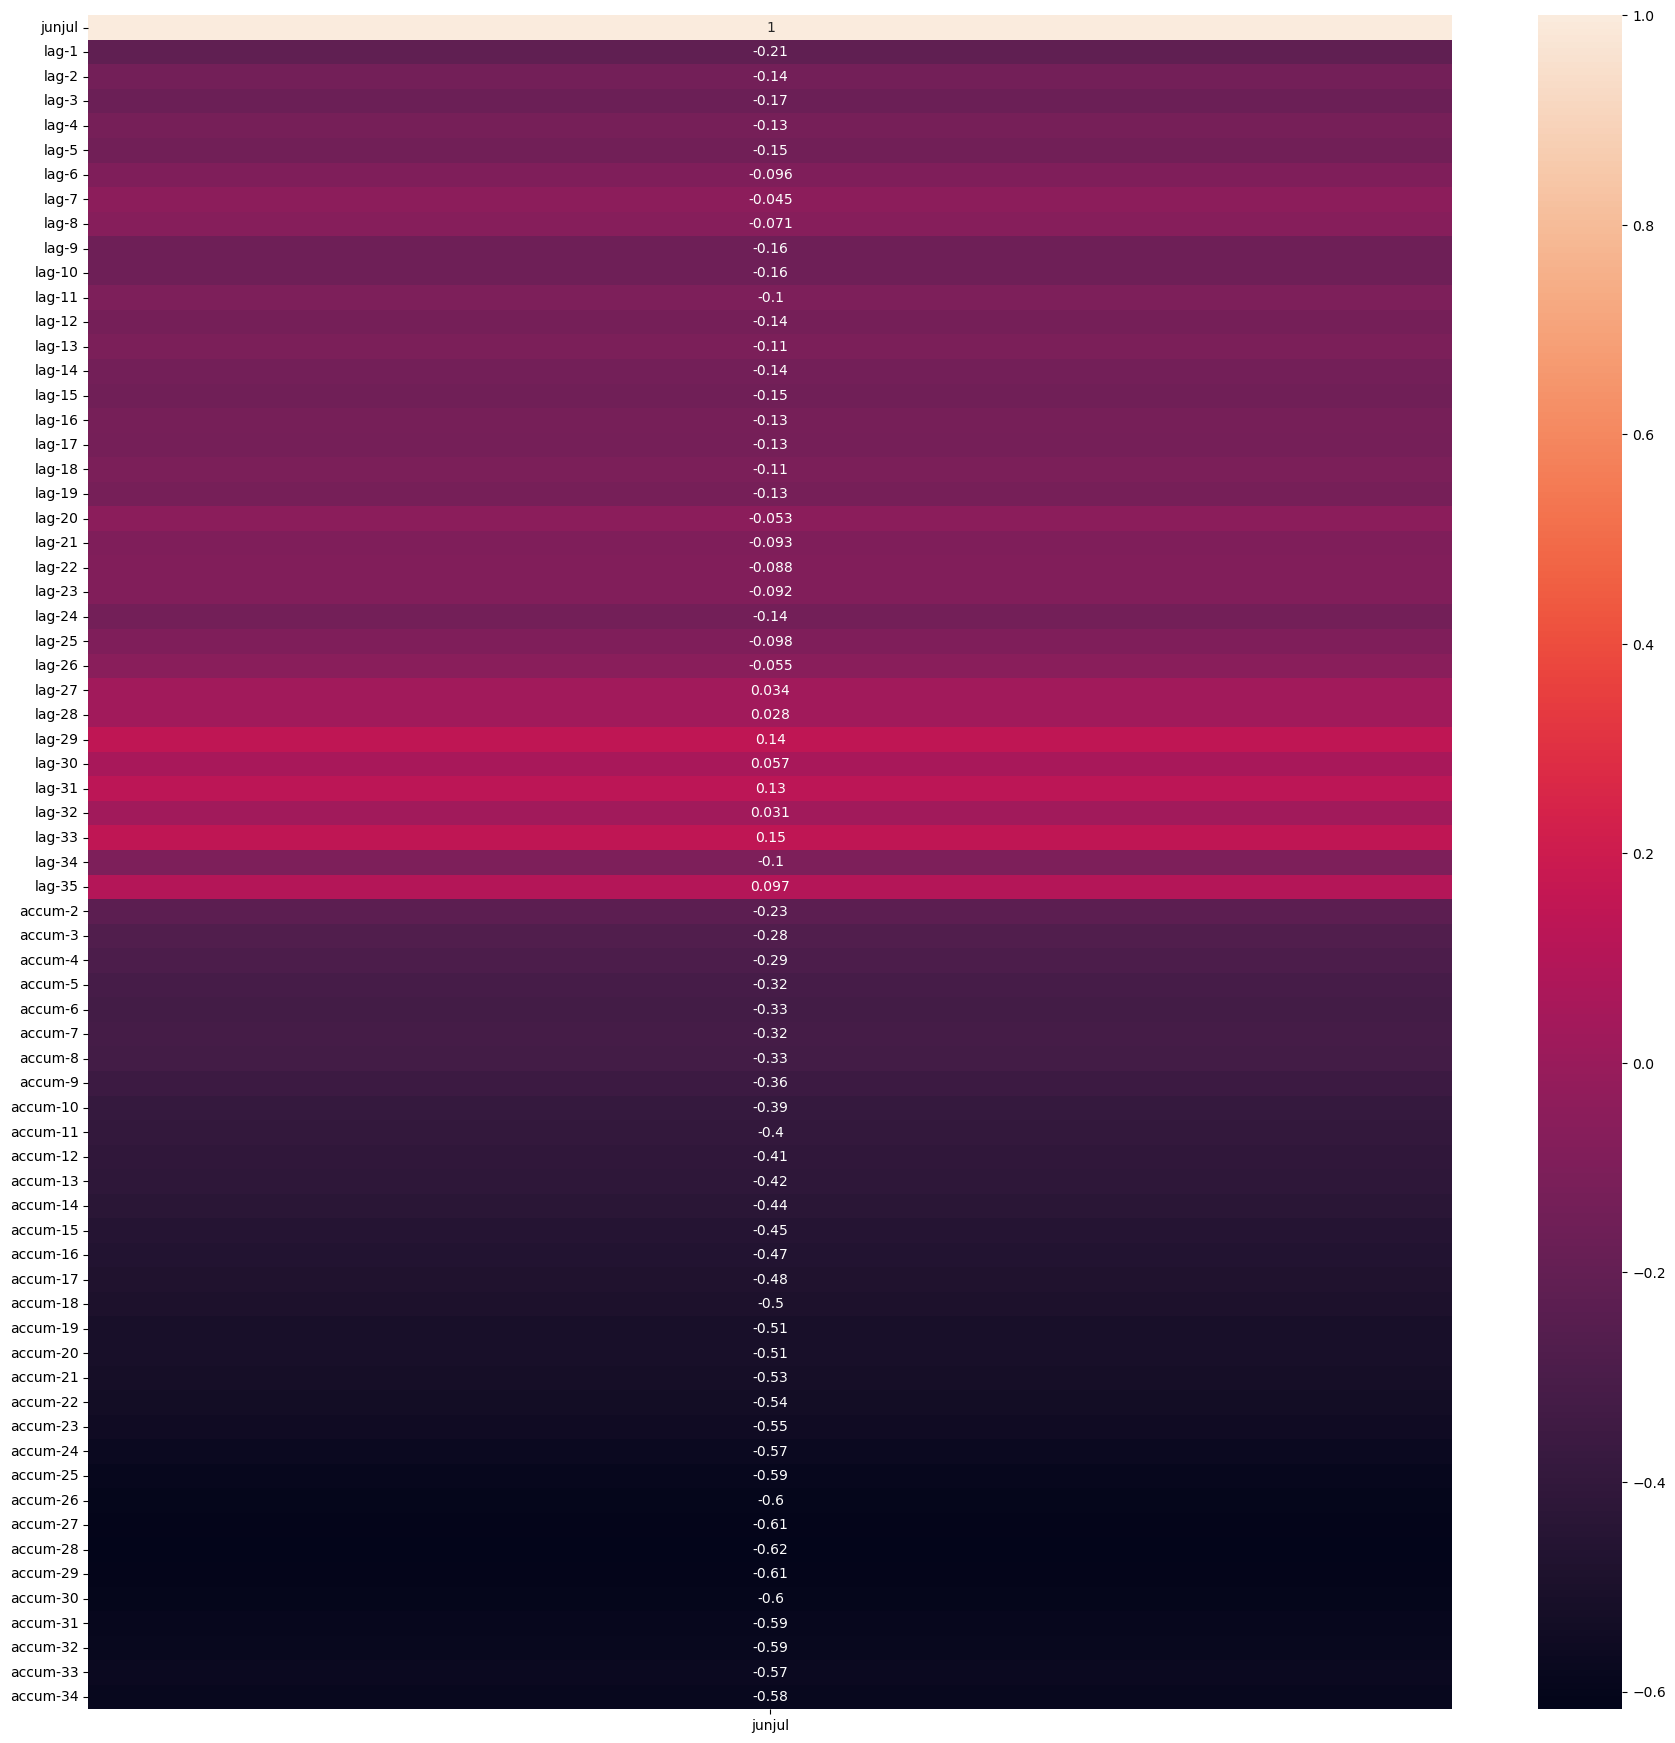

In [63]:
from matplotlib.pyplot import figure
figure(figsize=(22,22))
sns.heatmap(junjul.corr()[['junjul']],annot=True)

<AxesSubplot:>

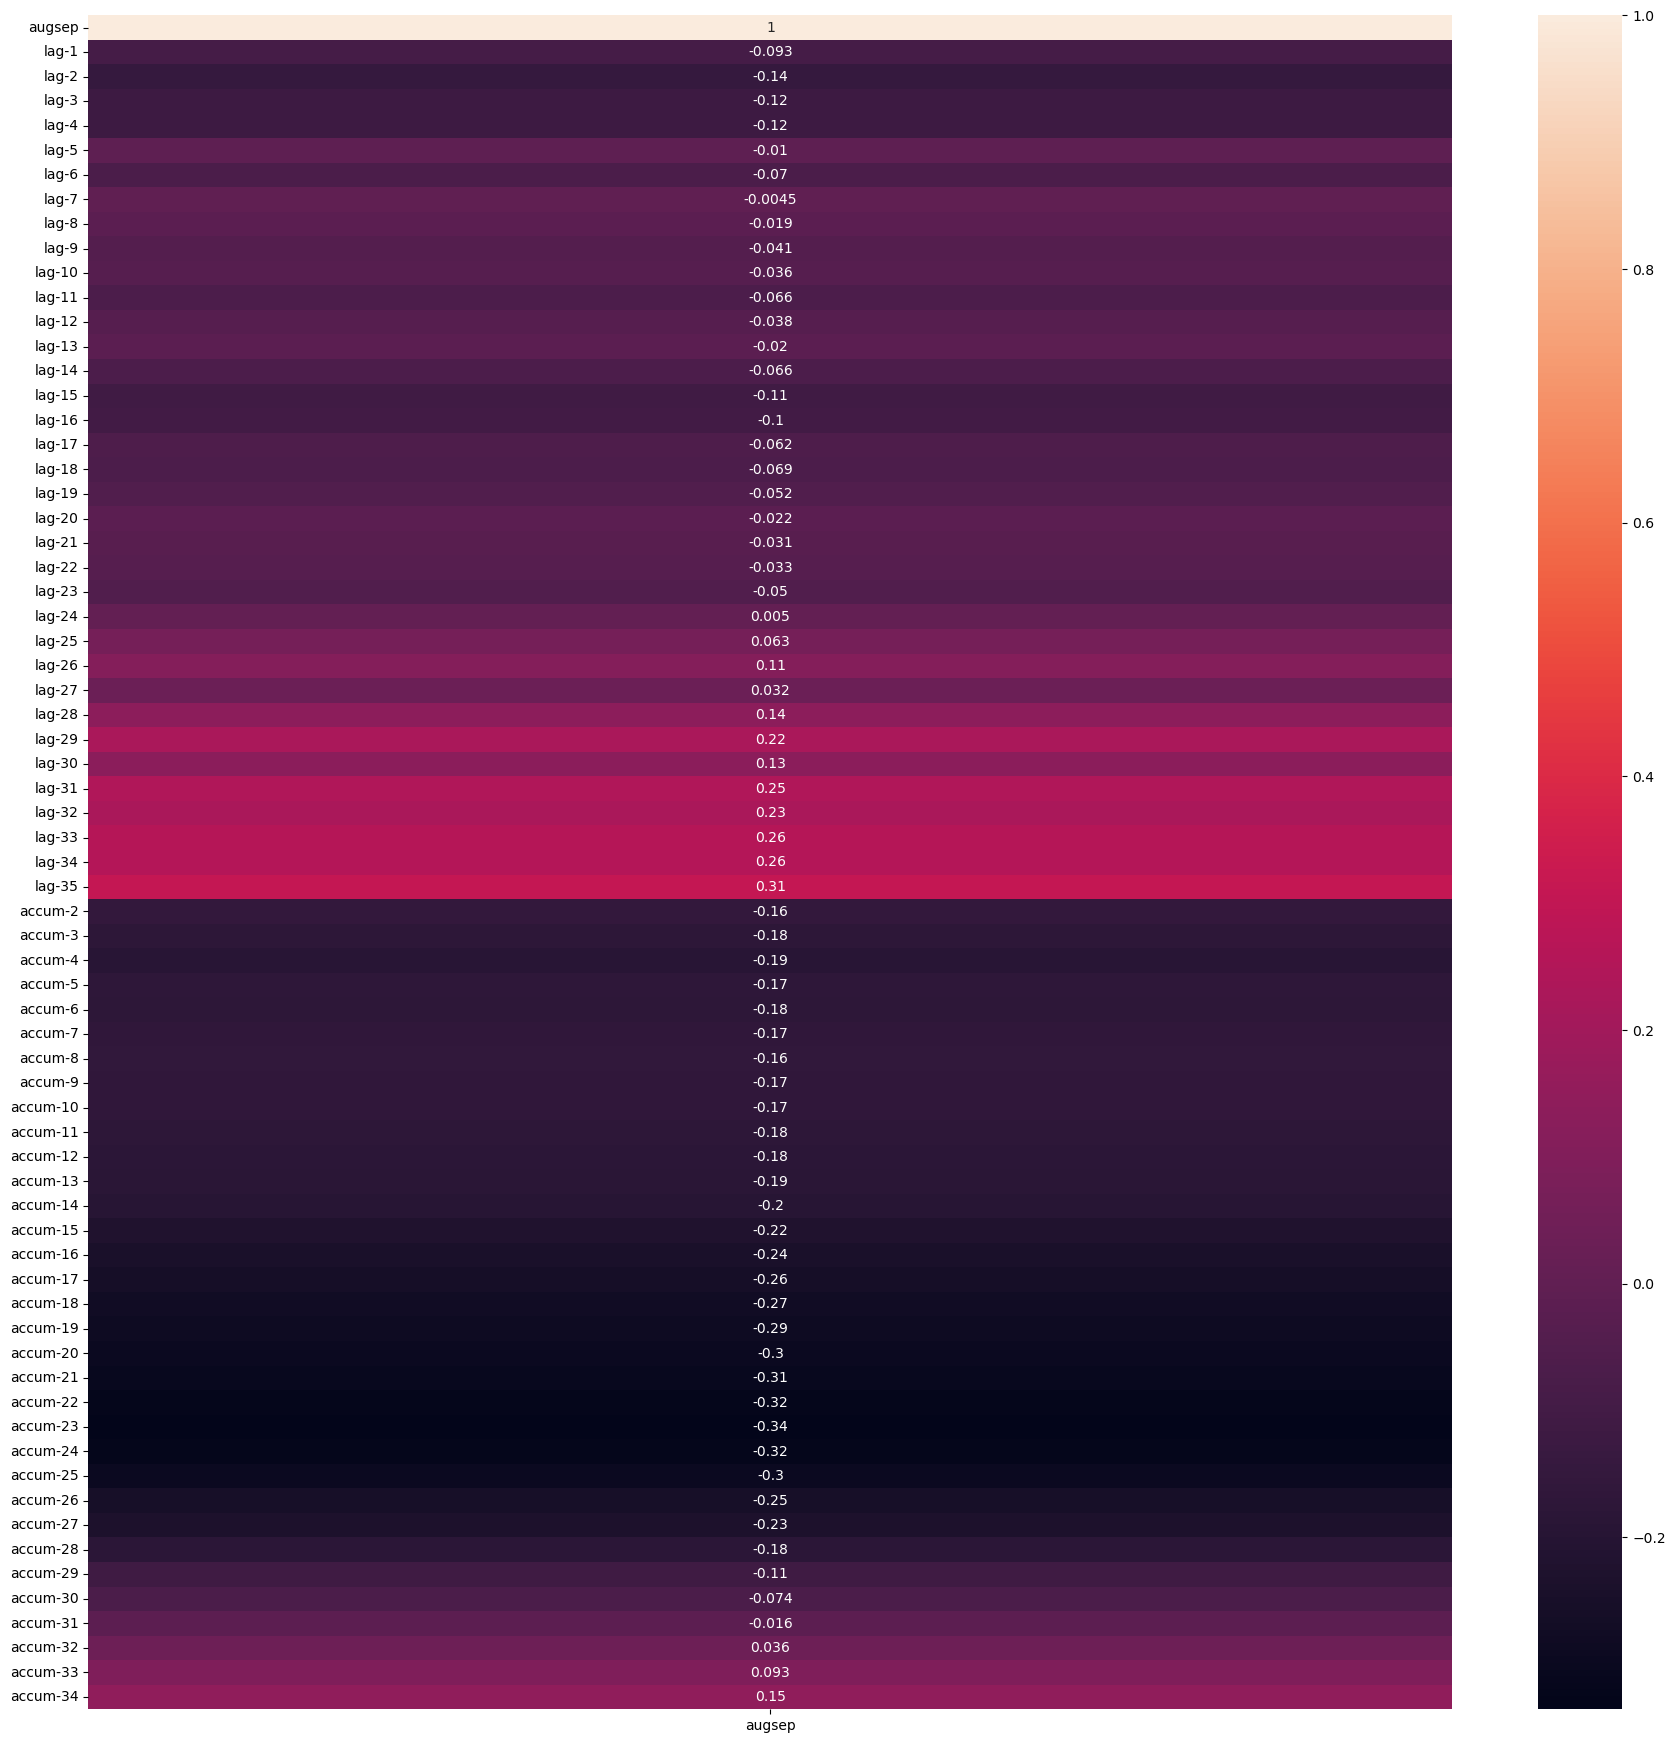

In [64]:
figure(figsize=(22,22))
sns.heatmap(augsep.corr()[['augsep']],annot=True)

In [27]:
#Considering data from jun to sept together
bucket['junsep'] = bucket[bucket.columns[:-2]][bucket.index.month.isin(range(6,10))].sum(axis=1)
junsep = bucket[bucket.index.month.isin(range(6,10))][['junsep']]

In [30]:
for i in range(1,36):
    delt2 = junsep.index-timedelta(i)
    junsep['lag-'+str(i)]= list(cutempo[cutempo.time.dt.date.isin(delt2.date)].values) + [0]
#     junjul['lag-'+str(i)]=champbuck[champbuck.time.dt.date.isin(delt.date)].values

In [31]:
for i in range(2,len(junsep.columns)-1):
    junsep['accum-'+str(i)] = junsep[junsep.columns[1:i+1]].sum(axis=1)

In [ ]:
##Compare correlations using the exact pixel of the location and spatial average of city rainfall

<AxesSubplot:>

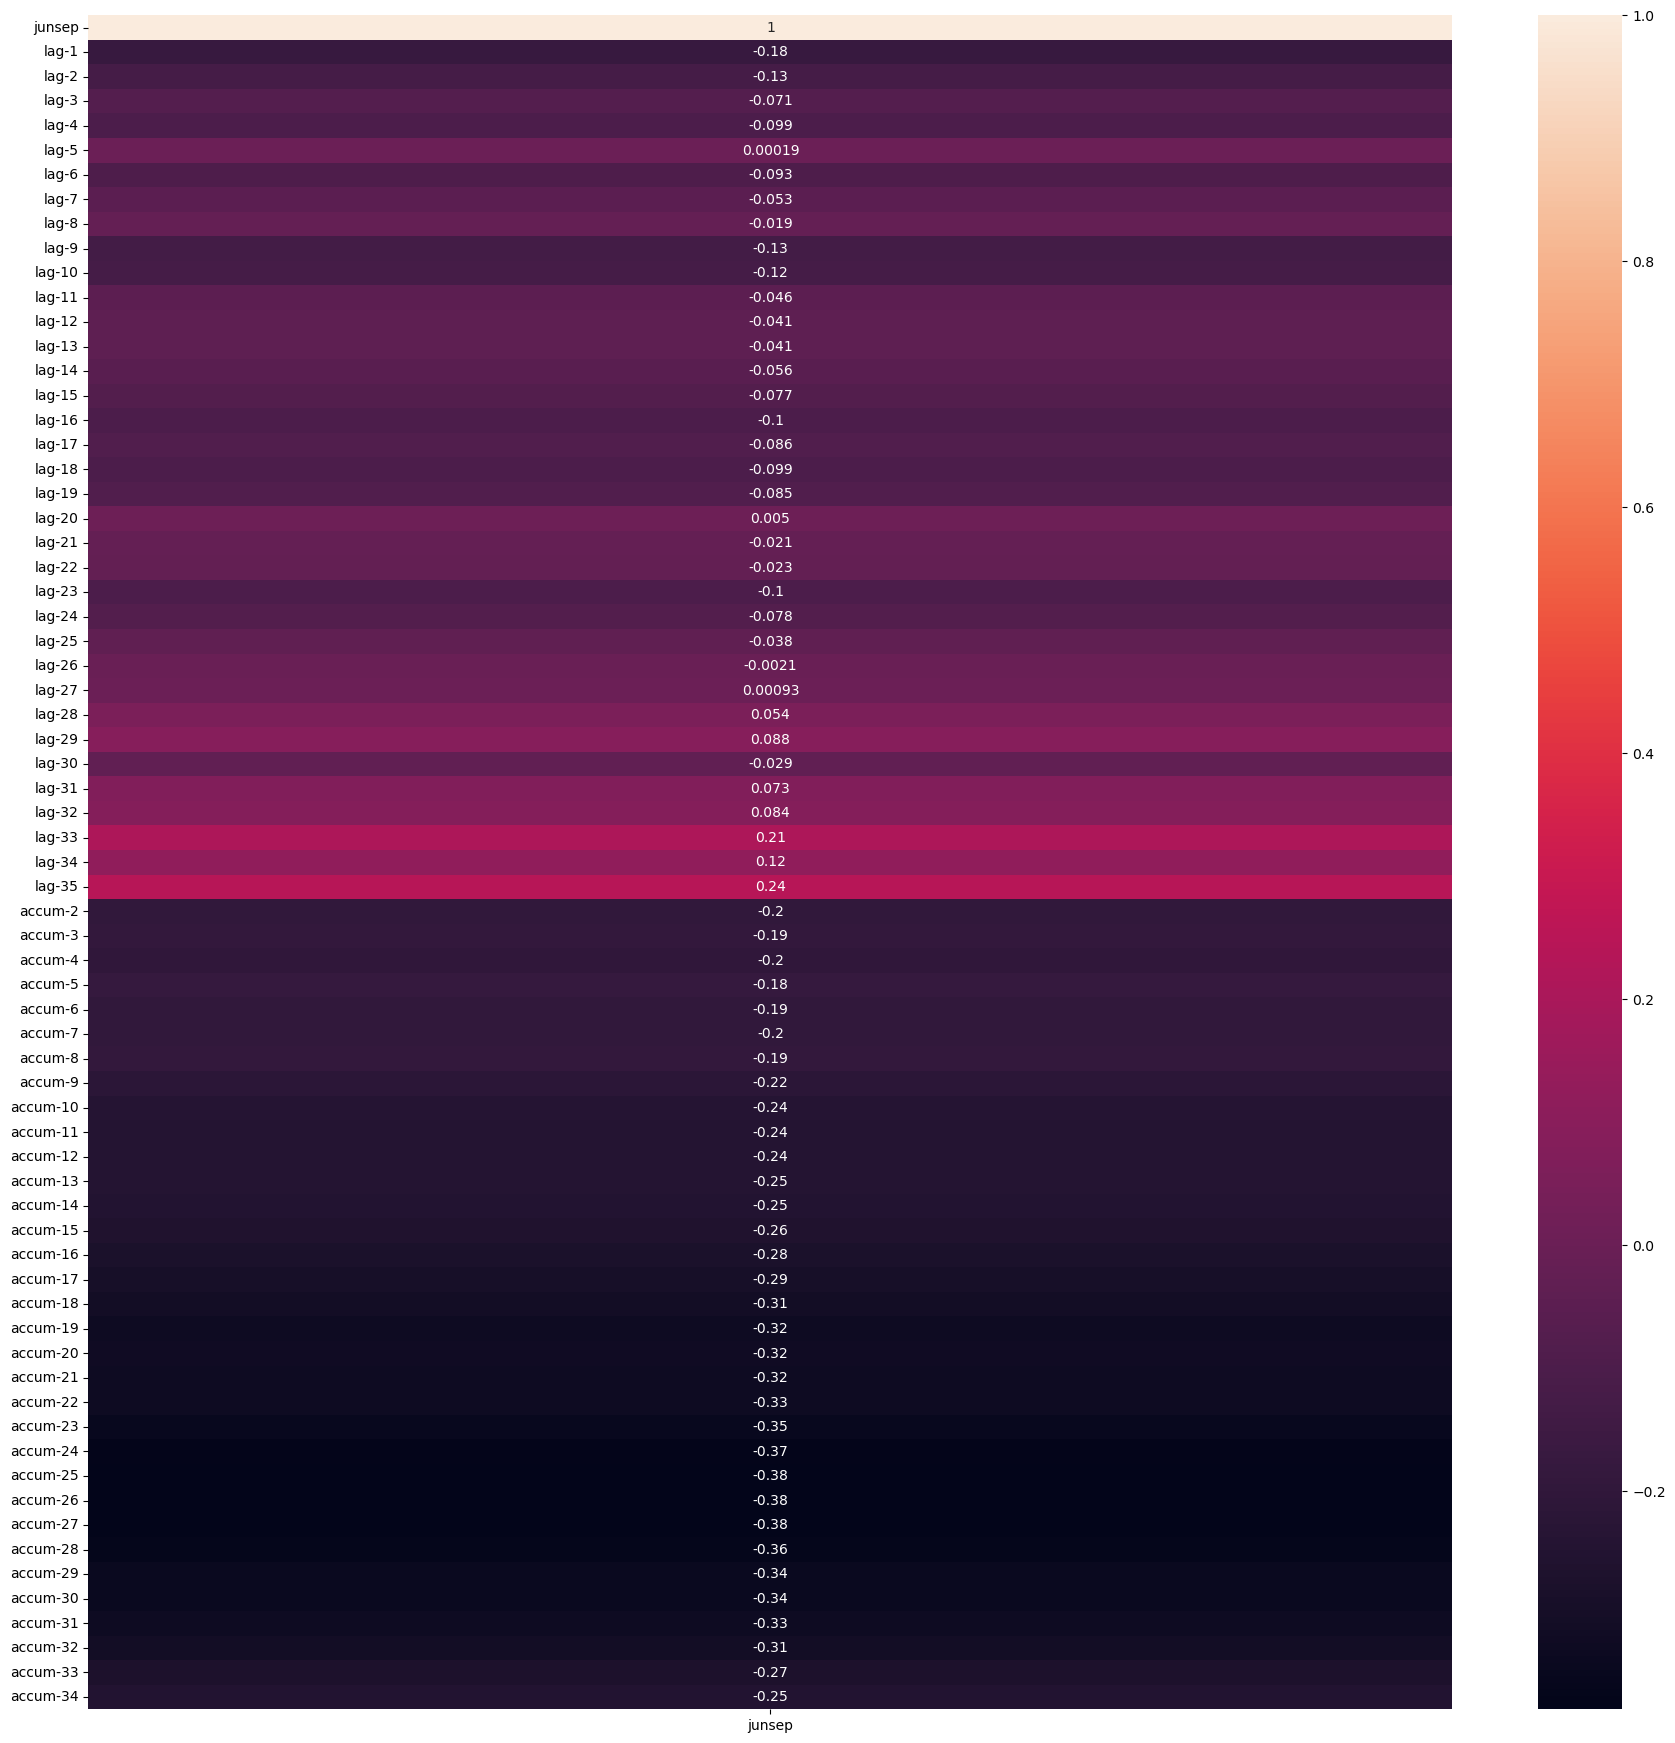

In [32]:
figure(figsize=(22,22))
sns.heatmap(junsep.corr()[['junsep']],annot=True)

In [60]:
roll = []
for i in range(2,15):
    rolling = junsep[junsep.columns[1:29]].rolling(i,axis=1).sum()
    rolling['larvae'] = junsep['junsep']
    rolling = rolling.drop('lag-1',axis=1)
    roll.append(rolling)

<AxesSubplot:>

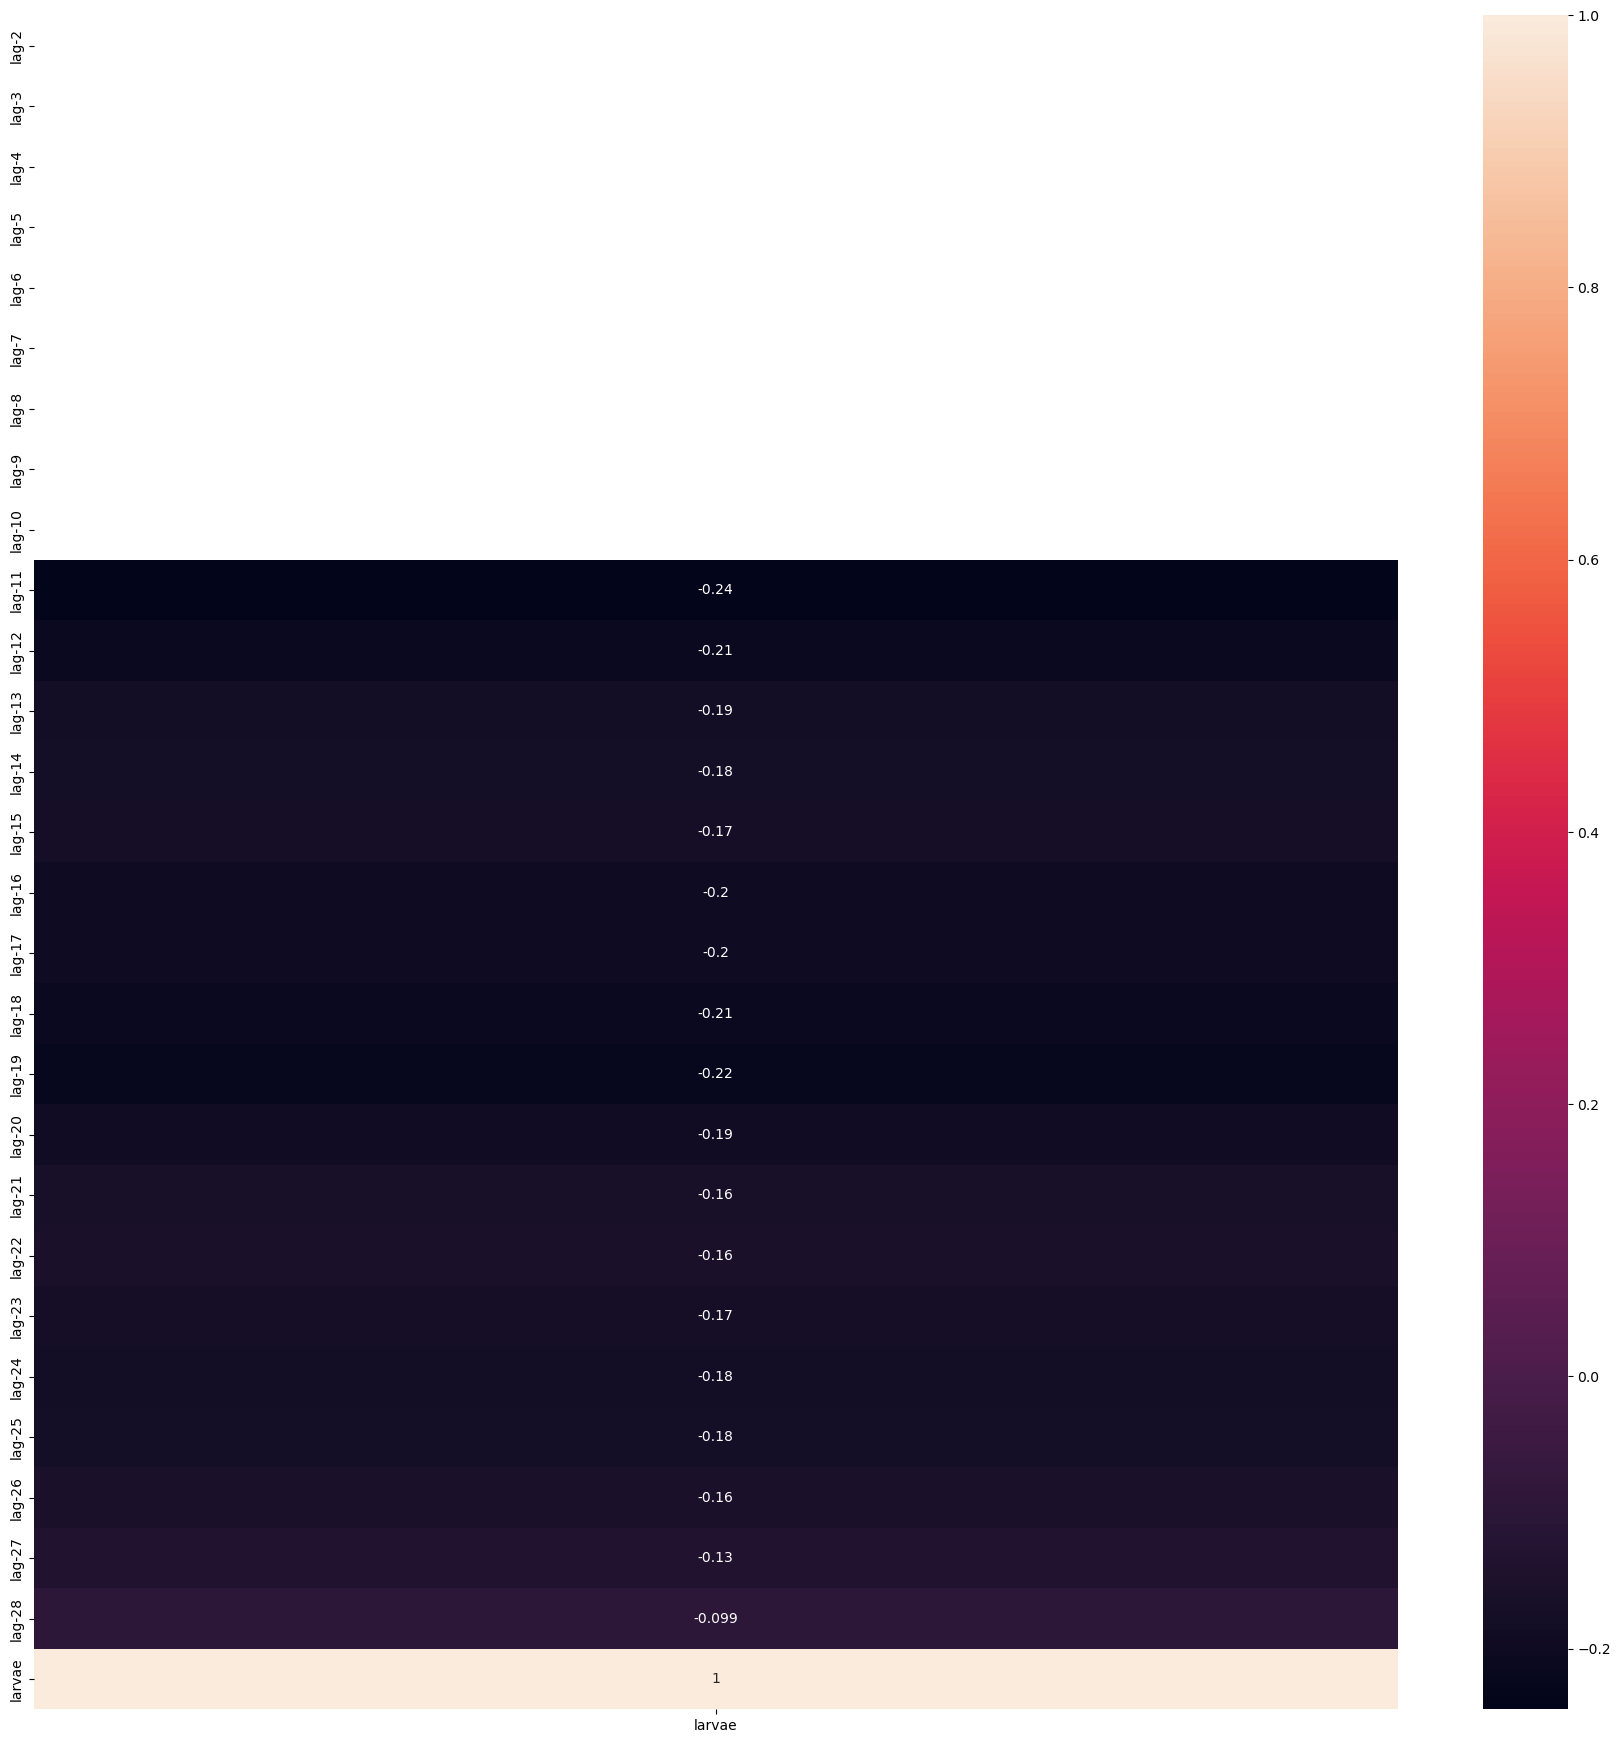

In [64]:
figure(figsize=(22,22))
sns.heatmap(roll[-4].corr()[['larvae']],annot=True)

# Other analysis

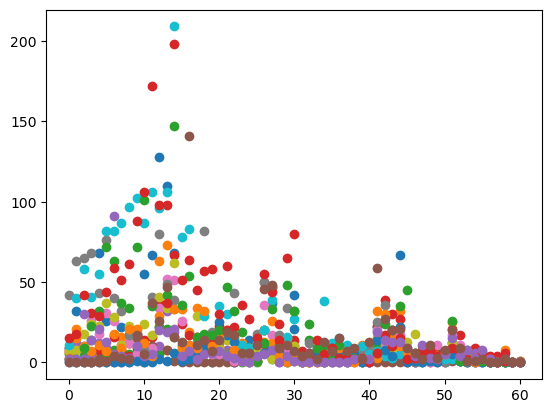

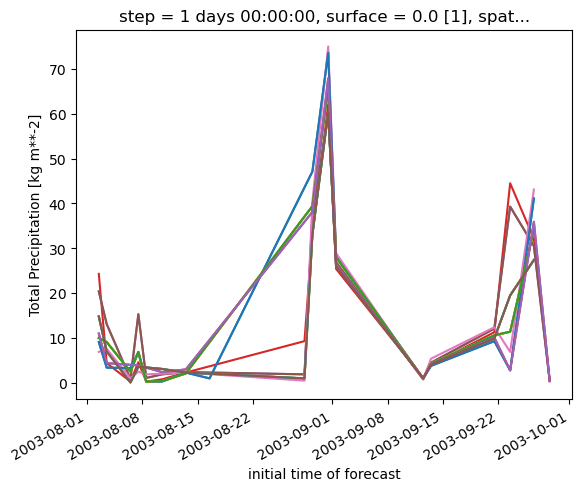

In [25]:
# for i in range(len(bucket.columns)):
#     plt.scatter(range(len(bucket[bucket.index.month>7])),bucket[bucket.index.month>7][bucket.columns[i]])
# plt.show()
# for i in range(len(bucket.columns)):
#     ppt = pptpix[i][pptpix[i].time.dt.year==2003]
#     ppt = ppt[(ppt.time.dt.month>7)&(ppt.time.dt.month<=9)]
#     ppt[ppt!=0].plot()

In [19]:
pptpix = [champcity.sel(x=buckgpd.iloc[i]['Lon'],y = buckgpd.iloc[i]['Lat'], method='nearest') for i in range(len(buckgpd))]

In [48]:
ppt67 = champcity[champcity.time.dt.year==2003]
ppt67 = ppt67[ppt67.time.dt.month.isin([8,9])]

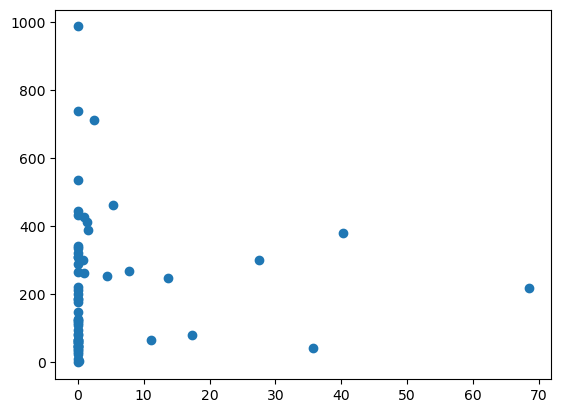

In [52]:
plt.scatter(ppt67.mean(('x','y')),augsep[:-1])
# plt.xlim(0,40)

In [20]:
pptpixdt = [i[i.time.dt.date.isin(bucket.index.date-timedelta(5))] for i in pptpix]

In [57]:
corlist = [pearsonr(pptpixdt[i][10:],bucket[bucket.columns[i]][10:134]) for i in range(len(pptpixdt))]

In [58]:
corlist

[(-0.08795141270877227, 0.33137377700168513),
 (-0.031189943138130657, 0.7309345207486169),
 (-0.020285091637253776, 0.8230525900259194),
 (-0.08545688208244194, 0.34532415687669654),
 (-0.08952135773827145, 0.32278126455640715),
 (-0.08017528294851031, 0.3760604781182462),
 (0.27979337081588773, 0.0016484314401368466),
 (-0.11838468405599292, 0.19035313794435402),
 (-0.09409540731054657, 0.29857287780939984),
 (-0.08351084190990196, 0.35646008591359357),
 (0.009700360908770248, 0.9148467539980952),
 (-0.03607117857391159, 0.6908269243296048),
 (0.02736109720077195, 0.7629180832409639),
 (-0.0418363583226411, 0.6445447515387888),
 (-0.03297309097302989, 0.7161917763485218),
 (-0.07211878137500236, 0.42604097374253813)]

<AxesSubplot:>

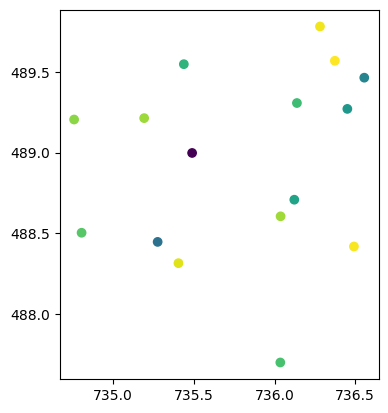

In [25]:
ax = plt.gca()
buckgpd.plot(ax=ax,column='% lar',cmap='viridis_r')

In [26]:
buck1 = locs[['Lat','Lon']]
for i in range(len(bucket.index)-1):
    buck1=buck1.append(locs[['Lat','Lon']])

/tmp/ipykernel_155862/1200509375.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  buck1=buck1.append(locs[['Lat','Lon']])
/tmp/ipykernel_155862/1200509375.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  buck1=buck1.append(locs[['Lat','Lon']])
/tmp/ipykernel_155862/1200509375.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  buck1=buck1.append(locs[['Lat','Lon']])
/tmp/ipykernel_155862/1200509375.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  buck1=buck1.append(locs[['Lat','Lon']])
/tmp/ipykernel_155862/1200509375.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version.

In [178]:
buck1['date']=sum([[i]*len(locs) for i in bucket.index],[])

In [179]:
buck1['larvae']= sum([list(bucket.T[i].values) for i in bucket.T.columns],[])

In [180]:
buck1.rename(index={'latlon':''})
buck1.set_index(['Lat','Lon','date'],inplace=True)

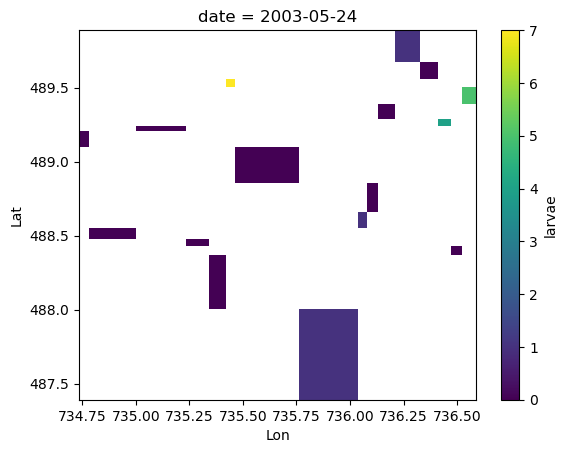

In [185]:

buk['larvae'].isel(date=5).plot()

In [199]:
# buk['larvae'][5][0][68]

<xarray.DataArray 'larvae' ()>
array(nan)
Coordinates:
    Lat      float64 488.6
    Lon      float64 734.8
    date     datetime64[ns] 2003-07-26

In [174]:
buk = buck1.to_xarray()

In [22]:
champ35= champcity[champcity.time.dt.year.isin([2003,2004,2005])]

In [23]:
spatavg = champ35.mean(dim=['y','x'])

In [28]:
extrain=champ35[champ35.time.isin(spatavg[spatavg>=20].time)]

In [27]:
extrain = extrain[extrain.time.dt.month.isin(range(5,10))]

In [17]:
stddf= pd.DataFrame({'std':sum([[extrain.sel(time=i).std().values for j in range(9)] for i in extrain.time],[]),'vals':sum([sum(extrain.sel(time=i).values.tolist(),[]) for i in extrain.time],[]),'time':sum([[i for j in range(9)] for i in extrain.time],[])})
stddf['avgrain'] = sum([[extrain.sel(time=i).mean(dim=['y','x']).values for j in range(9)] for i in extrain.time],[])

In [18]:
stddf = stddf.sort_values(by='std')
stddf['std'] = stddf['std'].apply(lambda x:round(float(x),2)).astype('str')

In [19]:
stddf['time']=[i.values for i in stddf['time']]

In [20]:
stddf = stddf.sort_values(by='avgrain')
stddf['avgrain'] = stddf['avgrain'].apply(lambda x:round(float(x),2)).astype('str')

Text(0.5, 0, 'time')

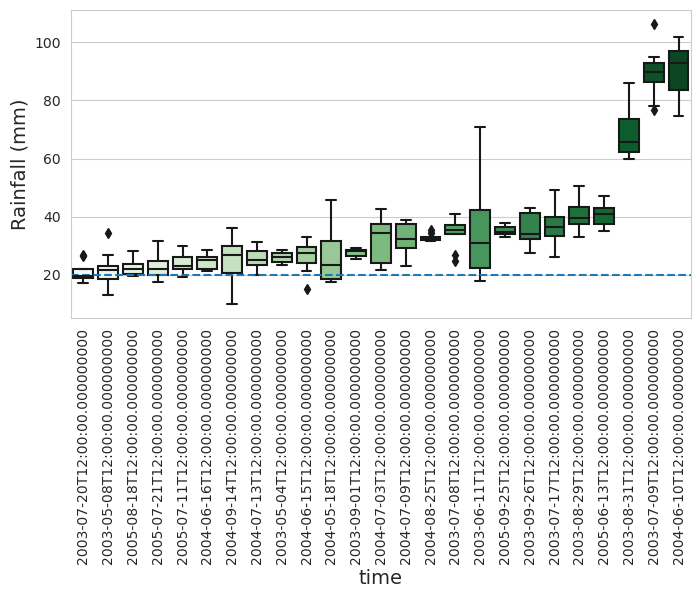

In [21]:
plt.figure(figsize=(8,4))
sns.set_style('whitegrid')
sns.boxplot(x='time',y='vals',data=stddf,palette='Greens')
plt.xticks(rotation=90)
plt.axhline(20,linestyle='dashed')
plt.ylabel('Rainfall (mm)',fontsize=14)
plt.xlabel('time',fontsize=14)

Text(0.5, 0, 'Spatially averaged rainfall (mm)')

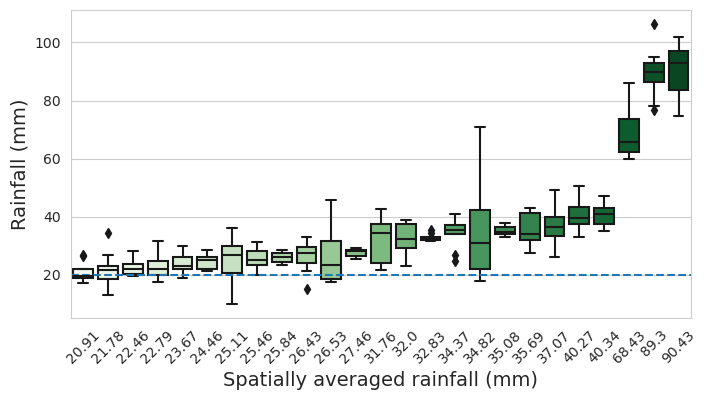

In [36]:
plt.figure(figsize=(8,4))
sns.set_style('whitegrid')
sns.boxplot(x='avgrain',y='vals',data=stddf,palette='Greens')
plt.xticks(rotation=45)
plt.axhline(20,linestyle='dashed')
plt.ylabel('Rainfall (mm)',fontsize=14)
plt.xlabel('Spatially averaged rainfall (mm)',fontsize=14)
# plt.title('Spatial distribution of rainfall on extreme avg. rainfall days')

In [31]:
quant = [np.quantile(sum(extrain.sel(time=i).values.tolist(),[]),0.75)-np.quantile(sum(extrain.sel(time=i).values.tolist(),[]),0.25) for i in extrain.time]

In [33]:
quantdf = pd.DataFrame({'time':extrain.time,'q':quant})

In [35]:
quantdf.sort_values(by='q')

time          q
13 2003-11-17 12:00:00   0.399998
38 2005-02-13 12:00:00   0.700001
29 2004-08-25 12:00:00   0.900002
45 2005-10-20 12:00:00   1.000000
33 2004-12-06 12:00:00   1.000000
34 2005-01-04 12:00:00   1.000000
19 2004-03-04 12:00:00   1.100000
15 2003-11-23 12:00:00   1.299999
31 2004-11-01 12:00:00   1.400000
37 2005-01-12 12:00:00   1.400002
46 2005-10-31 12:00:00   1.500000
0  2003-02-14 12:00:00   1.600000
11 2003-09-01 12:00:00   2.000000
14 2003-11-18 12:00:00   2.299999
35 2005-01-05 12:00:00   2.299999
44 2005-09-25 12:00:00   2.500000
18 2004-01-03 12:00:00   2.600000
8  2003-07-20 12:00:00   2.900000
36 2005-01-11 12:00:00   2.900002
5  2003-07-08 12:00:00   3.000000
32 2004-11-24 12:00:00   3.000000
2  2003-05-04 12:00:00   3.000000
43 2005-08-18 12:00:00   3.200001
47 2005-11-05 12:00:00   3.200001
21 2004-03-26 12:00:00   3.699997
41 2005-07-11 12:00:00   3.900000
25 2004-06-16 12:00:00   4.100000
3  2003-05-08 12:00:00   4.299999
28 2004-07-13 12:00:00   4.700001
17 2003-12-28 12:00:00   4.799999
42 2005-07-21 12:00:00   4.800001
39 2005-04-20 12:00:00   5.500000
24 2004-06-15 12:00:00   5.500000
40 2005-06-13 12:00:00   5.700001
9  2003-08-29 12:00:00   5.799999
7  2003-07-17 12:00:00   6.399998
6  2003-07-09 12:00:00   6.400002
16 2003-12-22 12:00:00   7.599998
27 2004-07-09 12:00:00   8.100002
12 2003-09-26 12:00:00   9.000000
20 2004-03-25 12:00:00   9.500000
30 2004-09-14 12:00:00   9.600000
10 2003-08-31 12:00:00  11.500000
22 2004-05-18 12:00:00  13.100000
23 2004-06-10 12:00:00  13.400002
26 2004-07-03 12:00:00  13.500000
1  2003-03-12 12:00:00  17.100000
4  2003-06-11 12:00:00  19.999998

Text(0.5, 1.0, 'Date=2004-06-10')

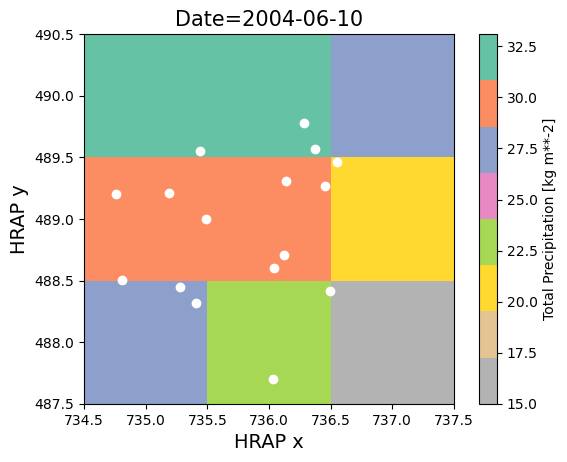

In [29]:
ax=plt.subplot(1,1,1)
# plt.plot(*geom_list_2[0].exterior.xy)
extrain.isel(time=24).plot(ax=ax,cmap='Set2_r')
buckgpd.plot(ax=ax,color='white',legend=True)
plt.xlabel('HRAP x',fontsize=14)
plt.ylabel('HRAP y',fontsize=14)
# plt.title('Precipitation grid and larvae bucket \n locations over C-U region')
plt.title('Date=2004-06-10',fontsize=15)

In [105]:
bucknc = bucket.to_xarray()
bucknc

<xarray.Dataset>
Dimensions:     (DATE: 135)
Coordinates:
  * DATE        (DATE) datetime64[ns] 2003-05-19 2003-05-20 ... 2003-09-30
Data variables: (12/17)
    SAVOY       (DATE) float64 0.0 2.0 0.0 1.0 3.0 1.0 ... 0.0 0.0 1.0 0.0 1.0
    NOVAK       (DATE) int64 0 0 0 3 0 0 0 2 9 2 2 23 ... 6 12 3 5 4 1 0 0 8 0 1
    CLAYTON     (DATE) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 2.0 0.0 0.0
    FH          (DATE) int64 0 0 0 0 3 7 24 3 10 14 13 ... 21 17 8 9 6 4 4 6 0 0
    NATURE      (DATE) int64 0 0 0 0 1 1 0 0 0 1 0 0 ... 3 0 7 1 3 6 2 0 0 0 0 0
    LAKE        (DATE) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    ...          ...
    CU          (DATE) int64 0 0 0 0 0 1 4 1 0 0 0 0 ... 5 25 4 1 0 7 1 0 1 0 0
    PIG         (DATE) int64 0 0 0 0 0 0 0 0 0 0 0 0 ... 7 26 1 2 2 1 0 0 0 0 0
    IVY         (DATE) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 1.0 0.0 1.0 0.0 0.0
    WINDSOR     (DATE) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 2.0 0.0 2.0 0.0 0.0
    SCHUH       (DATE) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 2.0 0.0 0.0
    sum         (DATE) float64 0.0 3.0 5.0 6.0 11.0 ... 10.0 4.0 24.0 0.0 2.0

In [2]:
import cfgrib
cfgrib.open_datasets('ST4.2006082812.24h')

ImportError: libffi.so.7: cannot open shared object file: No such file or directory

In [ ]:
# import tarfile
# my_tar = tarfile.open('/data/dhence/a/pborse2/inputdata/stage4.200201.tar')
# my_tar.extractall('/data/dhence/a/pborse2/inputdata')
# my_tar.close()